In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 919)
(4014968, 8)
validation
(782336, 919)
(782336, 8)
test
(325224, 919)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 11:31 - loss: 2.4473 - STD: 0.1265 - MAE: 0.2204

  4/402 [..............................] - ETA: 9s - loss: 2.1813 - STD: 0.0649 - MAE: 0.2179   

  7/402 [..............................] - ETA: 9s - loss: 2.1466 - STD: 0.0616 - MAE: 0.2170

 10/402 [..............................] - ETA: 9s - loss: 2.1351 - STD: 0.0579 - MAE: 0.2168

 13/402 [..............................] - ETA: 9s - loss: 2.1232 - STD: 0.0538 - MAE: 0.2168

 16/402 [>.............................] - ETA: 9s - loss: 2.1103 - STD: 0.0504 - MAE: 0.2168

 19/402 [>.............................] - ETA: 9s - loss: 2.1010 - STD: 0.0478 - MAE: 0.2167

 22/402 [>.............................] - ETA: 9s - loss: 2.0953 - STD: 0.0458 - MAE: 0.2168

 25/402 [>.............................] - ETA: 9s - loss: 2.0906 - STD: 0.0437 - MAE: 0.2168

 28/402 [=>............................] - ETA: 8s - loss: 2.0857 - STD: 0.0419 - MAE: 0.2168

 30/402 [=>............................] - ETA: 8s - loss: 2.0827 - STD: 0.0413 - MAE: 0.2168

 33/402 [=>............................] - ETA: 8s - loss: 2.0785 - STD: 0.0408 - MAE: 0.2167

 36/402 [=>............................] - ETA: 8s - loss: 2.0741 - STD: 0.0403 - MAE: 0.2166

 39/402 [=>............................] - ETA: 8s - loss: 2.0688 - STD: 0.0398 - MAE: 0.2165

 41/402 [==>...........................] - ETA: 8s - loss: 2.0648 - STD: 0.0397 - MAE: 0.2164

 44/402 [==>...........................] - ETA: 8s - loss: 2.0575 - STD: 0.0397 - MAE: 0.2162

 47/402 [==>...........................] - ETA: 8s - loss: 2.0488 - STD: 0.0401 - MAE: 0.2158

 50/402 [==>...........................] - ETA: 8s - loss: 2.0390 - STD: 0.0411 - MAE: 0.2155

 53/402 [==>...........................] - ETA: 8s - loss: 2.0290 - STD: 0.0426 - MAE: 0.2150

 56/402 [===>..........................] - ETA: 8s - loss: 2.0186 - STD: 0.0442 - MAE: 0.2145

 59/402 [===>..........................] - ETA: 8s - loss: 2.0086 - STD: 0.0460 - MAE: 0.2140

 62/402 [===>..........................] - ETA: 8s - loss: 1.9986 - STD: 0.0477 - MAE: 0.2135

 65/402 [===>..........................] - ETA: 8s - loss: 1.9892 - STD: 0.0494 - MAE: 0.2131

 68/402 [====>.........................] - ETA: 8s - loss: 1.9795 - STD: 0.0509 - MAE: 0.2126

 71/402 [====>.........................] - ETA: 7s - loss: 1.9702 - STD: 0.0524 - MAE: 0.2121

 74/402 [====>.........................] - ETA: 7s - loss: 1.9606 - STD: 0.0540 - MAE: 0.2117

 77/402 [====>.........................] - ETA: 7s - loss: 1.9512 - STD: 0.0555 - MAE: 0.2112

 79/402 [====>.........................] - ETA: 7s - loss: 1.9448 - STD: 0.0564 - MAE: 0.2109

 82/402 [=====>........................] - ETA: 7s - loss: 1.9353 - STD: 0.0577 - MAE: 0.2105

 85/402 [=====>........................] - ETA: 7s - loss: 1.9258 - STD: 0.0592 - MAE: 0.2100

 88/402 [=====>........................] - ETA: 7s - loss: 1.9162 - STD: 0.0605 - MAE: 0.2095

 90/402 [=====>........................] - ETA: 7s - loss: 1.9099 - STD: 0.0614 - MAE: 0.2092

 93/402 [=====>........................] - ETA: 7s - loss: 1.9001 - STD: 0.0627 - MAE: 0.2087

 96/402 [======>.......................] - ETA: 7s - loss: 1.8905 - STD: 0.0640 - MAE: 0.2082

 99/402 [======>.......................] - ETA: 7s - loss: 1.8814 - STD: 0.0654 - MAE: 0.2077

102/402 [======>.......................] - ETA: 7s - loss: 1.8720 - STD: 0.0667 - MAE: 0.2072

104/402 [======>.......................] - ETA: 7s - loss: 1.8659 - STD: 0.0677 - MAE: 0.2068

107/402 [======>.......................] - ETA: 7s - loss: 1.8569 - STD: 0.0691 - MAE: 0.2063

110/402 [=======>......................] - ETA: 7s - loss: 1.8479 - STD: 0.0705 - MAE: 0.2058

113/402 [=======>......................] - ETA: 6s - loss: 1.8390 - STD: 0.0719 - MAE: 0.2052

115/402 [=======>......................] - ETA: 6s - loss: 1.8333 - STD: 0.0728 - MAE: 0.2049

118/402 [=======>......................] - ETA: 6s - loss: 1.8248 - STD: 0.0741 - MAE: 0.2043

121/402 [========>.....................] - ETA: 6s - loss: 1.8164 - STD: 0.0755 - MAE: 0.2038

124/402 [========>.....................] - ETA: 6s - loss: 1.8083 - STD: 0.0768 - MAE: 0.2033

126/402 [========>.....................] - ETA: 6s - loss: 1.8028 - STD: 0.0776 - MAE: 0.2029

129/402 [========>.....................] - ETA: 6s - loss: 1.7945 - STD: 0.0788 - MAE: 0.2024

132/402 [========>.....................] - ETA: 6s - loss: 1.7862 - STD: 0.0801 - MAE: 0.2018

135/402 [=========>....................] - ETA: 6s - loss: 1.7780 - STD: 0.0813 - MAE: 0.2013

138/402 [=========>....................] - ETA: 6s - loss: 1.7700 - STD: 0.0826 - MAE: 0.2007

141/402 [=========>....................] - ETA: 6s - loss: 1.7619 - STD: 0.0838 - MAE: 0.2002

144/402 [=========>....................] - ETA: 6s - loss: 1.7538 - STD: 0.0850 - MAE: 0.1996

147/402 [=========>....................] - ETA: 6s - loss: 1.7458 - STD: 0.0863 - MAE: 0.1991

150/402 [==========>...................] - ETA: 6s - loss: 1.7379 - STD: 0.0875 - MAE: 0.1985

153/402 [==========>...................] - ETA: 5s - loss: 1.7301 - STD: 0.0887 - MAE: 0.1979

156/402 [==========>...................] - ETA: 5s - loss: 1.7225 - STD: 0.0900 - MAE: 0.1974

159/402 [==========>...................] - ETA: 5s - loss: 1.7150 - STD: 0.0912 - MAE: 0.1968

162/402 [===========>..................] - ETA: 5s - loss: 1.7078 - STD: 0.0924 - MAE: 0.1963

164/402 [===========>..................] - ETA: 5s - loss: 1.7029 - STD: 0.0932 - MAE: 0.1959

167/402 [===========>..................] - ETA: 5s - loss: 1.6958 - STD: 0.0944 - MAE: 0.1953

170/402 [===========>..................] - ETA: 5s - loss: 1.6888 - STD: 0.0955 - MAE: 0.1948

173/402 [===========>..................] - ETA: 5s - loss: 1.6821 - STD: 0.0967 - MAE: 0.1942

175/402 [============>.................] - ETA: 5s - loss: 1.6775 - STD: 0.0975 - MAE: 0.1939

178/402 [============>.................] - ETA: 5s - loss: 1.6710 - STD: 0.0986 - MAE: 0.1933

181/402 [============>.................] - ETA: 5s - loss: 1.6645 - STD: 0.0997 - MAE: 0.1928

184/402 [============>.................] - ETA: 5s - loss: 1.6583 - STD: 0.1008 - MAE: 0.1923

187/402 [============>.................] - ETA: 5s - loss: 1.6522 - STD: 0.1018 - MAE: 0.1918

190/402 [=============>................] - ETA: 5s - loss: 1.6462 - STD: 0.1028 - MAE: 0.1913

193/402 [=============>................] - ETA: 5s - loss: 1.6404 - STD: 0.1038 - MAE: 0.1908

196/402 [=============>................] - ETA: 4s - loss: 1.6347 - STD: 0.1048 - MAE: 0.1904

199/402 [=============>................] - ETA: 4s - loss: 1.6291 - STD: 0.1058 - MAE: 0.1899

202/402 [==============>...............] - ETA: 4s - loss: 1.6236 - STD: 0.1067 - MAE: 0.1895

205/402 [==============>...............] - ETA: 4s - loss: 1.6181 - STD: 0.1076 - MAE: 0.1890

208/402 [==============>...............] - ETA: 4s - loss: 1.6130 - STD: 0.1085 - MAE: 0.1886

211/402 [==============>...............] - ETA: 4s - loss: 1.6078 - STD: 0.1094 - MAE: 0.1881

214/402 [==============>...............] - ETA: 4s - loss: 1.6027 - STD: 0.1103 - MAE: 0.1877

217/402 [===============>..............] - ETA: 4s - loss: 1.5977 - STD: 0.1112 - MAE: 0.1873

220/402 [===============>..............] - ETA: 4s - loss: 1.5928 - STD: 0.1120 - MAE: 0.1869

223/402 [===============>..............] - ETA: 4s - loss: 1.5881 - STD: 0.1128 - MAE: 0.1865

226/402 [===============>..............] - ETA: 4s - loss: 1.5833 - STD: 0.1136 - MAE: 0.1861

229/402 [================>.............] - ETA: 4s - loss: 1.5789 - STD: 0.1144 - MAE: 0.1857

232/402 [================>.............] - ETA: 4s - loss: 1.5743 - STD: 0.1151 - MAE: 0.1853

235/402 [================>.............] - ETA: 4s - loss: 1.5700 - STD: 0.1159 - MAE: 0.1850

238/402 [================>.............] - ETA: 3s - loss: 1.5656 - STD: 0.1166 - MAE: 0.1846

241/402 [================>.............] - ETA: 3s - loss: 1.5612 - STD: 0.1174 - MAE: 0.1842

244/402 [=================>............] - ETA: 3s - loss: 1.5571 - STD: 0.1181 - MAE: 0.1839

247/402 [=================>............] - ETA: 3s - loss: 1.5528 - STD: 0.1188 - MAE: 0.1835

250/402 [=================>............] - ETA: 3s - loss: 1.5487 - STD: 0.1195 - MAE: 0.1831

253/402 [=================>............] - ETA: 3s - loss: 1.5447 - STD: 0.1202 - MAE: 0.1828

256/402 [==================>...........] - ETA: 3s - loss: 1.5407 - STD: 0.1209 - MAE: 0.1825

259/402 [==================>...........] - ETA: 3s - loss: 1.5368 - STD: 0.1215 - MAE: 0.1821

262/402 [==================>...........] - ETA: 3s - loss: 1.5332 - STD: 0.1222 - MAE: 0.1818

265/402 [==================>...........] - ETA: 3s - loss: 1.5301 - STD: 0.1228 - MAE: 0.1815

268/402 [===================>..........] - ETA: 3s - loss: 1.5266 - STD: 0.1234 - MAE: 0.1812

271/402 [===================>..........] - ETA: 3s - loss: 1.5231 - STD: 0.1240 - MAE: 0.1809

273/402 [===================>..........] - ETA: 3s - loss: 1.5207 - STD: 0.1244 - MAE: 0.1807

276/402 [===================>..........] - ETA: 3s - loss: 1.5172 - STD: 0.1250 - MAE: 0.1804

279/402 [===================>..........] - ETA: 2s - loss: 1.5137 - STD: 0.1256 - MAE: 0.1801

282/402 [====================>.........] - ETA: 2s - loss: 1.5103 - STD: 0.1262 - MAE: 0.1798

285/402 [====================>.........] - ETA: 2s - loss: 1.5071 - STD: 0.1267 - MAE: 0.1795

288/402 [====================>.........] - ETA: 2s - loss: 1.5038 - STD: 0.1273 - MAE: 0.1792

291/402 [====================>.........] - ETA: 2s - loss: 1.5006 - STD: 0.1279 - MAE: 0.1789

294/402 [====================>.........] - ETA: 2s - loss: 1.4973 - STD: 0.1284 - MAE: 0.1787

297/402 [=====================>........] - ETA: 2s - loss: 1.4942 - STD: 0.1289 - MAE: 0.1784

299/402 [=====================>........] - ETA: 2s - loss: 1.4921 - STD: 0.1293 - MAE: 0.1782

302/402 [=====================>........] - ETA: 2s - loss: 1.4888 - STD: 0.1298 - MAE: 0.1779

305/402 [=====================>........] - ETA: 2s - loss: 1.4857 - STD: 0.1303 - MAE: 0.1776

308/402 [=====================>........] - ETA: 2s - loss: 1.4829 - STD: 0.1308 - MAE: 0.1774

311/402 [======================>.......] - ETA: 2s - loss: 1.4799 - STD: 0.1313 - MAE: 0.1771

314/402 [======================>.......] - ETA: 2s - loss: 1.4769 - STD: 0.1318 - MAE: 0.1769

317/402 [======================>.......] - ETA: 2s - loss: 1.4740 - STD: 0.1323 - MAE: 0.1766

320/402 [======================>.......] - ETA: 1s - loss: 1.4712 - STD: 0.1328 - MAE: 0.1764

323/402 [=======================>......] - ETA: 1s - loss: 1.4684 - STD: 0.1333 - MAE: 0.1761

326/402 [=======================>......] - ETA: 1s - loss: 1.4658 - STD: 0.1337 - MAE: 0.1759

329/402 [=======================>......] - ETA: 1s - loss: 1.4631 - STD: 0.1342 - MAE: 0.1756

332/402 [=======================>......] - ETA: 1s - loss: 1.4606 - STD: 0.1346 - MAE: 0.1754

335/402 [========================>.....] - ETA: 1s - loss: 1.4579 - STD: 0.1351 - MAE: 0.1752

338/402 [========================>.....] - ETA: 1s - loss: 1.4552 - STD: 0.1355 - MAE: 0.1749

341/402 [========================>.....] - ETA: 1s - loss: 1.4527 - STD: 0.1360 - MAE: 0.1747

344/402 [========================>.....] - ETA: 1s - loss: 1.4502 - STD: 0.1364 - MAE: 0.1745

347/402 [========================>.....] - ETA: 1s - loss: 1.4476 - STD: 0.1368 - MAE: 0.1742

350/402 [=========================>....] - ETA: 1s - loss: 1.4452 - STD: 0.1372 - MAE: 0.1740

353/402 [=========================>....] - ETA: 1s - loss: 1.4427 - STD: 0.1376 - MAE: 0.1738

356/402 [=========================>....] - ETA: 1s - loss: 1.4404 - STD: 0.1380 - MAE: 0.1736

359/402 [=========================>....] - ETA: 1s - loss: 1.4384 - STD: 0.1384 - MAE: 0.1734

362/402 [==========================>...] - ETA: 1s - loss: 1.4360 - STD: 0.1388 - MAE: 0.1732

365/402 [==========================>...] - ETA: 0s - loss: 1.4336 - STD: 0.1392 - MAE: 0.1730

368/402 [==========================>...] - ETA: 0s - loss: 1.4312 - STD: 0.1396 - MAE: 0.1727

371/402 [==========================>...] - ETA: 0s - loss: 1.4288 - STD: 0.1400 - MAE: 0.1725

374/402 [==========================>...] - ETA: 0s - loss: 1.4264 - STD: 0.1404 - MAE: 0.1723

377/402 [===========================>..] - ETA: 0s - loss: 1.4240 - STD: 0.1407 - MAE: 0.1721

380/402 [===========================>..] - ETA: 0s - loss: 1.4216 - STD: 0.1411 - MAE: 0.1719

383/402 [===========================>..] - ETA: 0s - loss: 1.4194 - STD: 0.1415 - MAE: 0.1717

385/402 [===========================>..] - ETA: 0s - loss: 1.4183 - STD: 0.1418 - MAE: 0.1716

388/402 [===========================>..] - ETA: 0s - loss: 1.4164 - STD: 0.1421 - MAE: 0.1714

391/402 [============================>.] - ETA: 0s - loss: 1.4143 - STD: 0.1425 - MAE: 0.1712

394/402 [============================>.] - ETA: 0s - loss: 1.4122 - STD: 0.1428 - MAE: 0.1710

396/402 [============================>.] - ETA: 0s - loss: 1.4107 - STD: 0.1431 - MAE: 0.1709

399/402 [============================>.] - ETA: 0s - loss: 1.4086 - STD: 0.1434 - MAE: 0.1707

402/402 [==============================] - ETA: 0s - loss: 1.4065 - STD: 0.1437 - MAE: 0.1705

402/402 [==============================] - 14s 31ms/step - loss: 1.4065 - STD: 0.1437 - MAE: 0.1705 - val_loss: 1.6663 - val_STD: 0.1905 - val_MAE: 0.1654


Epoch 2/10000


  1/402 [..............................] - ETA: 20s - loss: 1.1365 - STD: 0.1883 - MAE: 0.1463

  4/402 [..............................] - ETA: 9s - loss: 1.1200 - STD: 0.1889 - MAE: 0.1450 

  7/402 [..............................] - ETA: 9s - loss: 1.1222 - STD: 0.1890 - MAE: 0.1450

  9/402 [..............................] - ETA: 9s - loss: 1.1201 - STD: 0.1893 - MAE: 0.1447

 12/402 [..............................] - ETA: 9s - loss: 1.1202 - STD: 0.1895 - MAE: 0.1447

 15/402 [>.............................] - ETA: 9s - loss: 1.1177 - STD: 0.1897 - MAE: 0.1445

 18/402 [>.............................] - ETA: 9s - loss: 1.1185 - STD: 0.1901 - MAE: 0.1444

 21/402 [>.............................] - ETA: 9s - loss: 1.1226 - STD: 0.1905 - MAE: 0.1444

 24/402 [>.............................] - ETA: 9s - loss: 1.1223 - STD: 0.1906 - MAE: 0.1444

 27/402 [=>............................] - ETA: 9s - loss: 1.1234 - STD: 0.1905 - MAE: 0.1445

 30/402 [=>............................] - ETA: 8s - loss: 1.1229 - STD: 0.1906 - MAE: 0.1444

 32/402 [=>............................] - ETA: 8s - loss: 1.1242 - STD: 0.1907 - MAE: 0.1444

 35/402 [=>............................] - ETA: 8s - loss: 1.1245 - STD: 0.1908 - MAE: 0.1444

 38/402 [=>............................] - ETA: 8s - loss: 1.1245 - STD: 0.1909 - MAE: 0.1444

 41/402 [==>...........................] - ETA: 8s - loss: 1.1238 - STD: 0.1909 - MAE: 0.1443

 44/402 [==>...........................] - ETA: 8s - loss: 1.1231 - STD: 0.1910 - MAE: 0.1443

 46/402 [==>...........................] - ETA: 8s - loss: 1.1220 - STD: 0.1910 - MAE: 0.1442

 49/402 [==>...........................] - ETA: 8s - loss: 1.1209 - STD: 0.1911 - MAE: 0.1441

 52/402 [==>...........................] - ETA: 8s - loss: 1.1200 - STD: 0.1912 - MAE: 0.1440

 55/402 [===>..........................] - ETA: 8s - loss: 1.1192 - STD: 0.1913 - MAE: 0.1439

 58/402 [===>..........................] - ETA: 8s - loss: 1.1183 - STD: 0.1914 - MAE: 0.1439

 61/402 [===>..........................] - ETA: 8s - loss: 1.1176 - STD: 0.1916 - MAE: 0.1438

 64/402 [===>..........................] - ETA: 8s - loss: 1.1168 - STD: 0.1916 - MAE: 0.1437

 67/402 [====>.........................] - ETA: 8s - loss: 1.1161 - STD: 0.1917 - MAE: 0.1436

 70/402 [====>.........................] - ETA: 7s - loss: 1.1162 - STD: 0.1918 - MAE: 0.1436

 73/402 [====>.........................] - ETA: 7s - loss: 1.1151 - STD: 0.1919 - MAE: 0.1435

 76/402 [====>.........................] - ETA: 7s - loss: 1.1144 - STD: 0.1920 - MAE: 0.1434

 79/402 [====>.........................] - ETA: 7s - loss: 1.1137 - STD: 0.1920 - MAE: 0.1434

 82/402 [=====>........................] - ETA: 7s - loss: 1.1141 - STD: 0.1922 - MAE: 0.1434

 85/402 [=====>........................] - ETA: 7s - loss: 1.1136 - STD: 0.1923 - MAE: 0.1433

 88/402 [=====>........................] - ETA: 7s - loss: 1.1135 - STD: 0.1924 - MAE: 0.1432

 91/402 [=====>........................] - ETA: 7s - loss: 1.1127 - STD: 0.1924 - MAE: 0.1432

 94/402 [======>.......................] - ETA: 7s - loss: 1.1122 - STD: 0.1925 - MAE: 0.1431

 96/402 [======>.......................] - ETA: 7s - loss: 1.1116 - STD: 0.1925 - MAE: 0.1431

 99/402 [======>.......................] - ETA: 7s - loss: 1.1109 - STD: 0.1926 - MAE: 0.1430

102/402 [======>.......................] - ETA: 7s - loss: 1.1104 - STD: 0.1927 - MAE: 0.1430

105/402 [======>.......................] - ETA: 7s - loss: 1.1100 - STD: 0.1928 - MAE: 0.1429

108/402 [=======>......................] - ETA: 7s - loss: 1.1094 - STD: 0.1928 - MAE: 0.1428

111/402 [=======>......................] - ETA: 7s - loss: 1.1091 - STD: 0.1929 - MAE: 0.1428

114/402 [=======>......................] - ETA: 6s - loss: 1.1084 - STD: 0.1930 - MAE: 0.1427

117/402 [=======>......................] - ETA: 6s - loss: 1.1079 - STD: 0.1931 - MAE: 0.1427

119/402 [=======>......................] - ETA: 6s - loss: 1.1074 - STD: 0.1931 - MAE: 0.1426

122/402 [========>.....................] - ETA: 6s - loss: 1.1073 - STD: 0.1932 - MAE: 0.1426

125/402 [========>.....................] - ETA: 6s - loss: 1.1067 - STD: 0.1932 - MAE: 0.1425

128/402 [========>.....................] - ETA: 6s - loss: 1.1061 - STD: 0.1933 - MAE: 0.1425

131/402 [========>.....................] - ETA: 6s - loss: 1.1051 - STD: 0.1934 - MAE: 0.1424

133/402 [========>.....................] - ETA: 6s - loss: 1.1047 - STD: 0.1935 - MAE: 0.1423

136/402 [=========>....................] - ETA: 6s - loss: 1.1041 - STD: 0.1935 - MAE: 0.1423

139/402 [=========>....................] - ETA: 6s - loss: 1.1033 - STD: 0.1936 - MAE: 0.1422

142/402 [=========>....................] - ETA: 6s - loss: 1.1030 - STD: 0.1937 - MAE: 0.1422

144/402 [=========>....................] - ETA: 6s - loss: 1.1029 - STD: 0.1938 - MAE: 0.1421

147/402 [=========>....................] - ETA: 6s - loss: 1.1024 - STD: 0.1938 - MAE: 0.1421

150/402 [==========>...................] - ETA: 6s - loss: 1.1017 - STD: 0.1939 - MAE: 0.1420

153/402 [==========>...................] - ETA: 6s - loss: 1.1010 - STD: 0.1940 - MAE: 0.1419

156/402 [==========>...................] - ETA: 5s - loss: 1.1003 - STD: 0.1941 - MAE: 0.1419

159/402 [==========>...................] - ETA: 5s - loss: 1.0997 - STD: 0.1941 - MAE: 0.1418

162/402 [===========>..................] - ETA: 5s - loss: 1.0992 - STD: 0.1942 - MAE: 0.1417

165/402 [===========>..................] - ETA: 5s - loss: 1.0993 - STD: 0.1943 - MAE: 0.1417

167/402 [===========>..................] - ETA: 5s - loss: 1.0990 - STD: 0.1943 - MAE: 0.1417

170/402 [===========>..................] - ETA: 5s - loss: 1.0987 - STD: 0.1944 - MAE: 0.1416

173/402 [===========>..................] - ETA: 5s - loss: 1.0981 - STD: 0.1945 - MAE: 0.1416

176/402 [============>.................] - ETA: 5s - loss: 1.0976 - STD: 0.1945 - MAE: 0.1415

179/402 [============>.................] - ETA: 5s - loss: 1.0971 - STD: 0.1946 - MAE: 0.1415

182/402 [============>.................] - ETA: 5s - loss: 1.0969 - STD: 0.1947 - MAE: 0.1414

185/402 [============>.................] - ETA: 5s - loss: 1.0964 - STD: 0.1947 - MAE: 0.1414

188/402 [=============>................] - ETA: 5s - loss: 1.0961 - STD: 0.1948 - MAE: 0.1413

191/402 [=============>................] - ETA: 5s - loss: 1.0957 - STD: 0.1949 - MAE: 0.1413

194/402 [=============>................] - ETA: 5s - loss: 1.0952 - STD: 0.1949 - MAE: 0.1413

196/402 [=============>................] - ETA: 4s - loss: 1.0949 - STD: 0.1950 - MAE: 0.1412

199/402 [=============>................] - ETA: 4s - loss: 1.0943 - STD: 0.1951 - MAE: 0.1412

202/402 [==============>...............] - ETA: 4s - loss: 1.0935 - STD: 0.1951 - MAE: 0.1411

205/402 [==============>...............] - ETA: 4s - loss: 1.0930 - STD: 0.1952 - MAE: 0.1410

208/402 [==============>...............] - ETA: 4s - loss: 1.0923 - STD: 0.1953 - MAE: 0.1410

211/402 [==============>...............] - ETA: 4s - loss: 1.0920 - STD: 0.1954 - MAE: 0.1409

214/402 [==============>...............] - ETA: 4s - loss: 1.0916 - STD: 0.1954 - MAE: 0.1409

217/402 [===============>..............] - ETA: 4s - loss: 1.0913 - STD: 0.1955 - MAE: 0.1408

220/402 [===============>..............] - ETA: 4s - loss: 1.0910 - STD: 0.1956 - MAE: 0.1408

222/402 [===============>..............] - ETA: 4s - loss: 1.0907 - STD: 0.1956 - MAE: 0.1407

225/402 [===============>..............] - ETA: 4s - loss: 1.0904 - STD: 0.1957 - MAE: 0.1407

228/402 [================>.............] - ETA: 4s - loss: 1.0898 - STD: 0.1957 - MAE: 0.1406

231/402 [================>.............] - ETA: 4s - loss: 1.0893 - STD: 0.1958 - MAE: 0.1406

234/402 [================>.............] - ETA: 4s - loss: 1.0887 - STD: 0.1959 - MAE: 0.1405

237/402 [================>.............] - ETA: 3s - loss: 1.0881 - STD: 0.1959 - MAE: 0.1405

240/402 [================>.............] - ETA: 3s - loss: 1.0877 - STD: 0.1960 - MAE: 0.1404

243/402 [=================>............] - ETA: 3s - loss: 1.0874 - STD: 0.1960 - MAE: 0.1404

245/402 [=================>............] - ETA: 3s - loss: 1.0871 - STD: 0.1961 - MAE: 0.1404

248/402 [=================>............] - ETA: 3s - loss: 1.0865 - STD: 0.1962 - MAE: 0.1403

251/402 [=================>............] - ETA: 3s - loss: 1.0858 - STD: 0.1962 - MAE: 0.1402

254/402 [=================>............] - ETA: 3s - loss: 1.0853 - STD: 0.1963 - MAE: 0.1402

257/402 [==================>...........] - ETA: 3s - loss: 1.0848 - STD: 0.1964 - MAE: 0.1401

260/402 [==================>...........] - ETA: 3s - loss: 1.0846 - STD: 0.1964 - MAE: 0.1401

263/402 [==================>...........] - ETA: 3s - loss: 1.0839 - STD: 0.1965 - MAE: 0.1400

266/402 [==================>...........] - ETA: 3s - loss: 1.0837 - STD: 0.1966 - MAE: 0.1400

269/402 [===================>..........] - ETA: 3s - loss: 1.0832 - STD: 0.1966 - MAE: 0.1399

271/402 [===================>..........] - ETA: 3s - loss: 1.0832 - STD: 0.1967 - MAE: 0.1399

274/402 [===================>..........] - ETA: 3s - loss: 1.0828 - STD: 0.1967 - MAE: 0.1399

277/402 [===================>..........] - ETA: 3s - loss: 1.0824 - STD: 0.1968 - MAE: 0.1398

280/402 [===================>..........] - ETA: 2s - loss: 1.0819 - STD: 0.1969 - MAE: 0.1398

282/402 [====================>.........] - ETA: 2s - loss: 1.0815 - STD: 0.1969 - MAE: 0.1397

285/402 [====================>.........] - ETA: 2s - loss: 1.0809 - STD: 0.1970 - MAE: 0.1397

288/402 [====================>.........] - ETA: 2s - loss: 1.0804 - STD: 0.1970 - MAE: 0.1396

291/402 [====================>.........] - ETA: 2s - loss: 1.0798 - STD: 0.1971 - MAE: 0.1396

294/402 [====================>.........] - ETA: 2s - loss: 1.0792 - STD: 0.1971 - MAE: 0.1395

297/402 [=====================>........] - ETA: 2s - loss: 1.0787 - STD: 0.1972 - MAE: 0.1394

300/402 [=====================>........] - ETA: 2s - loss: 1.0783 - STD: 0.1973 - MAE: 0.1394

303/402 [=====================>........] - ETA: 2s - loss: 1.0778 - STD: 0.1973 - MAE: 0.1393

306/402 [=====================>........] - ETA: 2s - loss: 1.0776 - STD: 0.1974 - MAE: 0.1393

309/402 [======================>.......] - ETA: 2s - loss: 1.0772 - STD: 0.1975 - MAE: 0.1393

312/402 [======================>.......] - ETA: 2s - loss: 1.0769 - STD: 0.1975 - MAE: 0.1392

315/402 [======================>.......] - ETA: 2s - loss: 1.0765 - STD: 0.1976 - MAE: 0.1392

318/402 [======================>.......] - ETA: 2s - loss: 1.0759 - STD: 0.1976 - MAE: 0.1391

321/402 [======================>.......] - ETA: 1s - loss: 1.0754 - STD: 0.1977 - MAE: 0.1391

324/402 [=======================>......] - ETA: 1s - loss: 1.0750 - STD: 0.1978 - MAE: 0.1390

327/402 [=======================>......] - ETA: 1s - loss: 1.0744 - STD: 0.1978 - MAE: 0.1390

330/402 [=======================>......] - ETA: 1s - loss: 1.0739 - STD: 0.1979 - MAE: 0.1389

333/402 [=======================>......] - ETA: 1s - loss: 1.0734 - STD: 0.1980 - MAE: 0.1389

335/402 [========================>.....] - ETA: 1s - loss: 1.0731 - STD: 0.1980 - MAE: 0.1388

338/402 [========================>.....] - ETA: 1s - loss: 1.0726 - STD: 0.1980 - MAE: 0.1388

341/402 [========================>.....] - ETA: 1s - loss: 1.0721 - STD: 0.1981 - MAE: 0.1387

344/402 [========================>.....] - ETA: 1s - loss: 1.0717 - STD: 0.1982 - MAE: 0.1387

347/402 [========================>.....] - ETA: 1s - loss: 1.0716 - STD: 0.1983 - MAE: 0.1386

350/402 [=========================>....] - ETA: 1s - loss: 1.0711 - STD: 0.1983 - MAE: 0.1386

353/402 [=========================>....] - ETA: 1s - loss: 1.0708 - STD: 0.1984 - MAE: 0.1385

356/402 [=========================>....] - ETA: 1s - loss: 1.0705 - STD: 0.1984 - MAE: 0.1385

359/402 [=========================>....] - ETA: 1s - loss: 1.0700 - STD: 0.1985 - MAE: 0.1384

362/402 [==========================>...] - ETA: 0s - loss: 1.0697 - STD: 0.1986 - MAE: 0.1384

365/402 [==========================>...] - ETA: 0s - loss: 1.0696 - STD: 0.1986 - MAE: 0.1384

368/402 [==========================>...] - ETA: 0s - loss: 1.0692 - STD: 0.1987 - MAE: 0.1383

371/402 [==========================>...] - ETA: 0s - loss: 1.0687 - STD: 0.1987 - MAE: 0.1383

374/402 [==========================>...] - ETA: 0s - loss: 1.0683 - STD: 0.1988 - MAE: 0.1382

376/402 [===========================>..] - ETA: 0s - loss: 1.0680 - STD: 0.1988 - MAE: 0.1382

379/402 [===========================>..] - ETA: 0s - loss: 1.0675 - STD: 0.1989 - MAE: 0.1382

382/402 [===========================>..] - ETA: 0s - loss: 1.0669 - STD: 0.1989 - MAE: 0.1381

385/402 [===========================>..] - ETA: 0s - loss: 1.0663 - STD: 0.1990 - MAE: 0.1380

388/402 [===========================>..] - ETA: 0s - loss: 1.0659 - STD: 0.1990 - MAE: 0.1380

391/402 [============================>.] - ETA: 0s - loss: 1.0653 - STD: 0.1991 - MAE: 0.1379

394/402 [============================>.] - ETA: 0s - loss: 1.0648 - STD: 0.1992 - MAE: 0.1379

397/402 [============================>.] - ETA: 0s - loss: 1.0646 - STD: 0.1993 - MAE: 0.1378

400/402 [============================>.] - ETA: 0s - loss: 1.0641 - STD: 0.1993 - MAE: 0.1378

402/402 [==============================] - 11s 28ms/step - loss: 1.0640 - STD: 0.1994 - MAE: 0.1378 - val_loss: 2.1231 - val_STD: 0.2161 - val_MAE: 0.1686


Epoch 3/10000


  1/402 [..............................] - ETA: 20s - loss: 1.0035 - STD: 0.2085 - MAE: 0.1304

  4/402 [..............................] - ETA: 9s - loss: 1.0009 - STD: 0.2082 - MAE: 0.1305 

  6/402 [..............................] - ETA: 9s - loss: 0.9989 - STD: 0.2079 - MAE: 0.1305

  9/402 [..............................] - ETA: 9s - loss: 1.0039 - STD: 0.2076 - MAE: 0.1309

 12/402 [..............................] - ETA: 9s - loss: 1.0047 - STD: 0.2078 - MAE: 0.1309

 15/402 [>.............................] - ETA: 9s - loss: 1.0027 - STD: 0.2078 - MAE: 0.1308

 17/402 [>.............................] - ETA: 9s - loss: 1.0044 - STD: 0.2077 - MAE: 0.1310

 20/402 [>.............................] - ETA: 9s - loss: 1.0035 - STD: 0.2077 - MAE: 0.1309

 23/402 [>.............................] - ETA: 9s - loss: 1.0025 - STD: 0.2078 - MAE: 0.1308

 26/402 [>.............................] - ETA: 9s - loss: 1.0007 - STD: 0.2078 - MAE: 0.1307

 29/402 [=>............................] - ETA: 8s - loss: 1.0002 - STD: 0.2078 - MAE: 0.1307

 32/402 [=>............................] - ETA: 8s - loss: 0.9994 - STD: 0.2078 - MAE: 0.1306

 35/402 [=>............................] - ETA: 8s - loss: 0.9981 - STD: 0.2079 - MAE: 0.1305

 38/402 [=>............................] - ETA: 8s - loss: 0.9975 - STD: 0.2080 - MAE: 0.1305

 41/402 [==>...........................] - ETA: 8s - loss: 0.9979 - STD: 0.2081 - MAE: 0.1305

 44/402 [==>...........................] - ETA: 8s - loss: 0.9972 - STD: 0.2082 - MAE: 0.1304

 47/402 [==>...........................] - ETA: 8s - loss: 0.9968 - STD: 0.2083 - MAE: 0.1303

 50/402 [==>...........................] - ETA: 8s - loss: 0.9962 - STD: 0.2084 - MAE: 0.1302

 53/402 [==>...........................] - ETA: 8s - loss: 0.9982 - STD: 0.2085 - MAE: 0.1303

 56/402 [===>..........................] - ETA: 8s - loss: 0.9988 - STD: 0.2086 - MAE: 0.1303

 59/402 [===>..........................] - ETA: 8s - loss: 0.9998 - STD: 0.2086 - MAE: 0.1304

 62/402 [===>..........................] - ETA: 8s - loss: 0.9999 - STD: 0.2086 - MAE: 0.1304

 65/402 [===>..........................] - ETA: 8s - loss: 0.9995 - STD: 0.2087 - MAE: 0.1303

 67/402 [====>.........................] - ETA: 8s - loss: 0.9993 - STD: 0.2087 - MAE: 0.1303

 70/402 [====>.........................] - ETA: 7s - loss: 0.9987 - STD: 0.2087 - MAE: 0.1303

 73/402 [====>.........................] - ETA: 7s - loss: 0.9981 - STD: 0.2088 - MAE: 0.1302

 76/402 [====>.........................] - ETA: 7s - loss: 0.9978 - STD: 0.2088 - MAE: 0.1302

 78/402 [====>.........................] - ETA: 7s - loss: 0.9974 - STD: 0.2088 - MAE: 0.1301

 81/402 [=====>........................] - ETA: 7s - loss: 0.9968 - STD: 0.2089 - MAE: 0.1301

 84/402 [=====>........................] - ETA: 7s - loss: 0.9960 - STD: 0.2089 - MAE: 0.1300

 86/402 [=====>........................] - ETA: 7s - loss: 0.9956 - STD: 0.2090 - MAE: 0.1300

 89/402 [=====>........................] - ETA: 7s - loss: 0.9950 - STD: 0.2090 - MAE: 0.1299

 91/402 [=====>........................] - ETA: 7s - loss: 0.9946 - STD: 0.2091 - MAE: 0.1299

 94/402 [======>.......................] - ETA: 7s - loss: 0.9938 - STD: 0.2091 - MAE: 0.1298

 97/402 [======>.......................] - ETA: 7s - loss: 0.9932 - STD: 0.2092 - MAE: 0.1297

100/402 [======>.......................] - ETA: 7s - loss: 0.9931 - STD: 0.2093 - MAE: 0.1297

102/402 [======>.......................] - ETA: 7s - loss: 0.9928 - STD: 0.2093 - MAE: 0.1297

105/402 [======>.......................] - ETA: 7s - loss: 0.9926 - STD: 0.2093 - MAE: 0.1296

108/402 [=======>......................] - ETA: 7s - loss: 0.9927 - STD: 0.2094 - MAE: 0.1296

111/402 [=======>......................] - ETA: 6s - loss: 0.9920 - STD: 0.2094 - MAE: 0.1296

114/402 [=======>......................] - ETA: 6s - loss: 0.9916 - STD: 0.2095 - MAE: 0.1295

117/402 [=======>......................] - ETA: 6s - loss: 0.9915 - STD: 0.2095 - MAE: 0.1295

120/402 [=======>......................] - ETA: 6s - loss: 0.9911 - STD: 0.2096 - MAE: 0.1294

123/402 [========>.....................] - ETA: 6s - loss: 0.9910 - STD: 0.2096 - MAE: 0.1294

125/402 [========>.....................] - ETA: 6s - loss: 0.9908 - STD: 0.2097 - MAE: 0.1294

127/402 [========>.....................] - ETA: 6s - loss: 0.9904 - STD: 0.2097 - MAE: 0.1293

130/402 [========>.....................] - ETA: 6s - loss: 0.9898 - STD: 0.2098 - MAE: 0.1293

133/402 [========>.....................] - ETA: 6s - loss: 0.9892 - STD: 0.2098 - MAE: 0.1292

136/402 [=========>....................] - ETA: 6s - loss: 0.9887 - STD: 0.2099 - MAE: 0.1292

138/402 [=========>....................] - ETA: 6s - loss: 0.9884 - STD: 0.2099 - MAE: 0.1292

141/402 [=========>....................] - ETA: 6s - loss: 0.9879 - STD: 0.2099 - MAE: 0.1291

144/402 [=========>....................] - ETA: 6s - loss: 0.9878 - STD: 0.2100 - MAE: 0.1291

147/402 [=========>....................] - ETA: 6s - loss: 0.9873 - STD: 0.2100 - MAE: 0.1290

150/402 [==========>...................] - ETA: 6s - loss: 0.9870 - STD: 0.2101 - MAE: 0.1290

153/402 [==========>...................] - ETA: 6s - loss: 0.9868 - STD: 0.2102 - MAE: 0.1290

156/402 [==========>...................] - ETA: 5s - loss: 0.9862 - STD: 0.2102 - MAE: 0.1289

159/402 [==========>...................] - ETA: 5s - loss: 0.9858 - STD: 0.2103 - MAE: 0.1288

162/402 [===========>..................] - ETA: 5s - loss: 0.9852 - STD: 0.2103 - MAE: 0.1288

165/402 [===========>..................] - ETA: 5s - loss: 0.9849 - STD: 0.2104 - MAE: 0.1287

168/402 [===========>..................] - ETA: 5s - loss: 0.9845 - STD: 0.2105 - MAE: 0.1287

171/402 [===========>..................] - ETA: 5s - loss: 0.9841 - STD: 0.2105 - MAE: 0.1287

174/402 [===========>..................] - ETA: 5s - loss: 0.9839 - STD: 0.2105 - MAE: 0.1286

177/402 [============>.................] - ETA: 5s - loss: 0.9835 - STD: 0.2106 - MAE: 0.1286

180/402 [============>.................] - ETA: 5s - loss: 0.9832 - STD: 0.2106 - MAE: 0.1285

183/402 [============>.................] - ETA: 5s - loss: 0.9828 - STD: 0.2107 - MAE: 0.1285

185/402 [============>.................] - ETA: 5s - loss: 0.9825 - STD: 0.2107 - MAE: 0.1284

188/402 [=============>................] - ETA: 5s - loss: 0.9822 - STD: 0.2108 - MAE: 0.1284

191/402 [=============>................] - ETA: 5s - loss: 0.9816 - STD: 0.2109 - MAE: 0.1283

194/402 [=============>................] - ETA: 5s - loss: 0.9814 - STD: 0.2109 - MAE: 0.1283

197/402 [=============>................] - ETA: 4s - loss: 0.9811 - STD: 0.2110 - MAE: 0.1283

199/402 [=============>................] - ETA: 4s - loss: 0.9808 - STD: 0.2110 - MAE: 0.1282

202/402 [==============>...............] - ETA: 4s - loss: 0.9806 - STD: 0.2110 - MAE: 0.1282

205/402 [==============>...............] - ETA: 4s - loss: 0.9805 - STD: 0.2111 - MAE: 0.1282

208/402 [==============>...............] - ETA: 4s - loss: 0.9800 - STD: 0.2111 - MAE: 0.1281

211/402 [==============>...............] - ETA: 4s - loss: 0.9797 - STD: 0.2112 - MAE: 0.1281

213/402 [==============>...............] - ETA: 4s - loss: 0.9794 - STD: 0.2112 - MAE: 0.1281

216/402 [===============>..............] - ETA: 4s - loss: 0.9790 - STD: 0.2113 - MAE: 0.1280

219/402 [===============>..............] - ETA: 4s - loss: 0.9787 - STD: 0.2113 - MAE: 0.1280

222/402 [===============>..............] - ETA: 4s - loss: 0.9785 - STD: 0.2113 - MAE: 0.1280

224/402 [===============>..............] - ETA: 4s - loss: 0.9787 - STD: 0.2114 - MAE: 0.1280

227/402 [===============>..............] - ETA: 4s - loss: 0.9784 - STD: 0.2114 - MAE: 0.1279

230/402 [================>.............] - ETA: 4s - loss: 0.9780 - STD: 0.2115 - MAE: 0.1279

233/402 [================>.............] - ETA: 4s - loss: 0.9775 - STD: 0.2115 - MAE: 0.1278

236/402 [================>.............] - ETA: 4s - loss: 0.9769 - STD: 0.2115 - MAE: 0.1278

239/402 [================>.............] - ETA: 3s - loss: 0.9766 - STD: 0.2116 - MAE: 0.1277

242/402 [=================>............] - ETA: 3s - loss: 0.9765 - STD: 0.2117 - MAE: 0.1277

245/402 [=================>............] - ETA: 3s - loss: 0.9762 - STD: 0.2117 - MAE: 0.1277

248/402 [=================>............] - ETA: 3s - loss: 0.9760 - STD: 0.2117 - MAE: 0.1277

251/402 [=================>............] - ETA: 3s - loss: 0.9755 - STD: 0.2118 - MAE: 0.1276

254/402 [=================>............] - ETA: 3s - loss: 0.9754 - STD: 0.2118 - MAE: 0.1276

257/402 [==================>...........] - ETA: 3s - loss: 0.9751 - STD: 0.2119 - MAE: 0.1276

260/402 [==================>...........] - ETA: 3s - loss: 0.9748 - STD: 0.2119 - MAE: 0.1275

263/402 [==================>...........] - ETA: 3s - loss: 0.9745 - STD: 0.2119 - MAE: 0.1275

266/402 [==================>...........] - ETA: 3s - loss: 0.9745 - STD: 0.2120 - MAE: 0.1275

269/402 [===================>..........] - ETA: 3s - loss: 0.9743 - STD: 0.2120 - MAE: 0.1274

272/402 [===================>..........] - ETA: 3s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1274

274/402 [===================>..........] - ETA: 3s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1274

277/402 [===================>..........] - ETA: 3s - loss: 0.9739 - STD: 0.2121 - MAE: 0.1274

280/402 [===================>..........] - ETA: 2s - loss: 0.9737 - STD: 0.2122 - MAE: 0.1273

283/402 [====================>.........] - ETA: 2s - loss: 0.9737 - STD: 0.2122 - MAE: 0.1273

286/402 [====================>.........] - ETA: 2s - loss: 0.9734 - STD: 0.2123 - MAE: 0.1273

288/402 [====================>.........] - ETA: 2s - loss: 0.9732 - STD: 0.2123 - MAE: 0.1273

291/402 [====================>.........] - ETA: 2s - loss: 0.9730 - STD: 0.2123 - MAE: 0.1272

294/402 [====================>.........] - ETA: 2s - loss: 0.9726 - STD: 0.2123 - MAE: 0.1272

297/402 [=====================>........] - ETA: 2s - loss: 0.9723 - STD: 0.2124 - MAE: 0.1272

299/402 [=====================>........] - ETA: 2s - loss: 0.9721 - STD: 0.2124 - MAE: 0.1271

302/402 [=====================>........] - ETA: 2s - loss: 0.9718 - STD: 0.2125 - MAE: 0.1271

305/402 [=====================>........] - ETA: 2s - loss: 0.9715 - STD: 0.2125 - MAE: 0.1271

308/402 [=====================>........] - ETA: 2s - loss: 0.9712 - STD: 0.2125 - MAE: 0.1270

311/402 [======================>.......] - ETA: 2s - loss: 0.9708 - STD: 0.2126 - MAE: 0.1270

314/402 [======================>.......] - ETA: 2s - loss: 0.9705 - STD: 0.2126 - MAE: 0.1270

317/402 [======================>.......] - ETA: 2s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1269

320/402 [======================>.......] - ETA: 1s - loss: 0.9698 - STD: 0.2127 - MAE: 0.1269

323/402 [=======================>......] - ETA: 1s - loss: 0.9694 - STD: 0.2127 - MAE: 0.1269

325/402 [=======================>......] - ETA: 1s - loss: 0.9692 - STD: 0.2127 - MAE: 0.1268

328/402 [=======================>......] - ETA: 1s - loss: 0.9689 - STD: 0.2128 - MAE: 0.1268

331/402 [=======================>......] - ETA: 1s - loss: 0.9686 - STD: 0.2128 - MAE: 0.1268

334/402 [=======================>......] - ETA: 1s - loss: 0.9683 - STD: 0.2129 - MAE: 0.1267

337/402 [========================>.....] - ETA: 1s - loss: 0.9679 - STD: 0.2129 - MAE: 0.1267

339/402 [========================>.....] - ETA: 1s - loss: 0.9677 - STD: 0.2129 - MAE: 0.1267

342/402 [========================>.....] - ETA: 1s - loss: 0.9674 - STD: 0.2130 - MAE: 0.1266

345/402 [========================>.....] - ETA: 1s - loss: 0.9672 - STD: 0.2130 - MAE: 0.1266

348/402 [========================>.....] - ETA: 1s - loss: 0.9671 - STD: 0.2131 - MAE: 0.1266

350/402 [=========================>....] - ETA: 1s - loss: 0.9669 - STD: 0.2131 - MAE: 0.1265

353/402 [=========================>....] - ETA: 1s - loss: 0.9669 - STD: 0.2131 - MAE: 0.1265

356/402 [=========================>....] - ETA: 1s - loss: 0.9665 - STD: 0.2132 - MAE: 0.1265

359/402 [=========================>....] - ETA: 1s - loss: 0.9663 - STD: 0.2132 - MAE: 0.1265

362/402 [==========================>...] - ETA: 0s - loss: 0.9661 - STD: 0.2132 - MAE: 0.1264

365/402 [==========================>...] - ETA: 0s - loss: 0.9660 - STD: 0.2133 - MAE: 0.1264

368/402 [==========================>...] - ETA: 0s - loss: 0.9657 - STD: 0.2133 - MAE: 0.1264

371/402 [==========================>...] - ETA: 0s - loss: 0.9654 - STD: 0.2133 - MAE: 0.1264

374/402 [==========================>...] - ETA: 0s - loss: 0.9651 - STD: 0.2134 - MAE: 0.1263

377/402 [===========================>..] - ETA: 0s - loss: 0.9647 - STD: 0.2134 - MAE: 0.1263

380/402 [===========================>..] - ETA: 0s - loss: 0.9643 - STD: 0.2134 - MAE: 0.1262

383/402 [===========================>..] - ETA: 0s - loss: 0.9640 - STD: 0.2135 - MAE: 0.1262

386/402 [===========================>..] - ETA: 0s - loss: 0.9638 - STD: 0.2135 - MAE: 0.1262

389/402 [============================>.] - ETA: 0s - loss: 0.9635 - STD: 0.2136 - MAE: 0.1262

392/402 [============================>.] - ETA: 0s - loss: 0.9632 - STD: 0.2136 - MAE: 0.1261

395/402 [============================>.] - ETA: 0s - loss: 0.9628 - STD: 0.2136 - MAE: 0.1261

398/402 [============================>.] - ETA: 0s - loss: 0.9625 - STD: 0.2137 - MAE: 0.1260

400/402 [============================>.] - ETA: 0s - loss: 0.9623 - STD: 0.2137 - MAE: 0.1260

402/402 [==============================] - 11s 28ms/step - loss: 0.9621 - STD: 0.2137 - MAE: 0.1260 - val_loss: 2.4376 - val_STD: 0.2278 - val_MAE: 0.1710


Epoch 4/10000


  1/402 [..............................] - ETA: 20s - loss: 0.9112 - STD: 0.2202 - MAE: 0.1202

  4/402 [..............................] - ETA: 9s - loss: 0.9208 - STD: 0.2201 - MAE: 0.1208 

  7/402 [..............................] - ETA: 9s - loss: 0.9177 - STD: 0.2191 - MAE: 0.1210

  9/402 [..............................] - ETA: 9s - loss: 0.9150 - STD: 0.2188 - MAE: 0.1210

 12/402 [..............................] - ETA: 9s - loss: 0.9170 - STD: 0.2190 - MAE: 0.1211

 15/402 [>.............................] - ETA: 9s - loss: 0.9163 - STD: 0.2191 - MAE: 0.1210

 18/402 [>.............................] - ETA: 9s - loss: 0.9138 - STD: 0.2190 - MAE: 0.1208

 21/402 [>.............................] - ETA: 9s - loss: 0.9189 - STD: 0.2192 - MAE: 0.1211

 23/402 [>.............................] - ETA: 9s - loss: 0.9247 - STD: 0.2193 - MAE: 0.1214

 26/402 [>.............................] - ETA: 9s - loss: 0.9251 - STD: 0.2193 - MAE: 0.1214

 29/402 [=>............................] - ETA: 9s - loss: 0.9282 - STD: 0.2191 - MAE: 0.1216

 32/402 [=>............................] - ETA: 8s - loss: 0.9273 - STD: 0.2193 - MAE: 0.1215

 34/402 [=>............................] - ETA: 8s - loss: 0.9263 - STD: 0.2192 - MAE: 0.1215

 37/402 [=>............................] - ETA: 8s - loss: 0.9249 - STD: 0.2191 - MAE: 0.1215

 40/402 [=>............................] - ETA: 8s - loss: 0.9235 - STD: 0.2191 - MAE: 0.1214

 43/402 [==>...........................] - ETA: 8s - loss: 0.9229 - STD: 0.2191 - MAE: 0.1213

 46/402 [==>...........................] - ETA: 8s - loss: 0.9217 - STD: 0.2191 - MAE: 0.1212

 48/402 [==>...........................] - ETA: 8s - loss: 0.9210 - STD: 0.2191 - MAE: 0.1212

 51/402 [==>...........................] - ETA: 8s - loss: 0.9198 - STD: 0.2192 - MAE: 0.1211

 54/402 [===>..........................] - ETA: 8s - loss: 0.9189 - STD: 0.2192 - MAE: 0.1210

 57/402 [===>..........................] - ETA: 8s - loss: 0.9185 - STD: 0.2193 - MAE: 0.1210

 60/402 [===>..........................] - ETA: 8s - loss: 0.9179 - STD: 0.2194 - MAE: 0.1209

 63/402 [===>..........................] - ETA: 8s - loss: 0.9175 - STD: 0.2194 - MAE: 0.1209

 66/402 [===>..........................] - ETA: 8s - loss: 0.9181 - STD: 0.2195 - MAE: 0.1209

 69/402 [====>.........................] - ETA: 7s - loss: 0.9171 - STD: 0.2195 - MAE: 0.1208

 72/402 [====>.........................] - ETA: 7s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1208

 74/402 [====>.........................] - ETA: 7s - loss: 0.9176 - STD: 0.2196 - MAE: 0.1208

 77/402 [====>.........................] - ETA: 7s - loss: 0.9176 - STD: 0.2196 - MAE: 0.1208

 80/402 [====>.........................] - ETA: 7s - loss: 0.9168 - STD: 0.2197 - MAE: 0.1207

 83/402 [=====>........................] - ETA: 7s - loss: 0.9160 - STD: 0.2197 - MAE: 0.1207

 86/402 [=====>........................] - ETA: 7s - loss: 0.9153 - STD: 0.2198 - MAE: 0.1206

 89/402 [=====>........................] - ETA: 7s - loss: 0.9149 - STD: 0.2198 - MAE: 0.1206

 92/402 [=====>........................] - ETA: 7s - loss: 0.9146 - STD: 0.2199 - MAE: 0.1205

 95/402 [======>.......................] - ETA: 7s - loss: 0.9149 - STD: 0.2200 - MAE: 0.1205

 98/402 [======>.......................] - ETA: 7s - loss: 0.9148 - STD: 0.2200 - MAE: 0.1205

100/402 [======>.......................] - ETA: 7s - loss: 0.9153 - STD: 0.2200 - MAE: 0.1205

103/402 [======>.......................] - ETA: 7s - loss: 0.9159 - STD: 0.2201 - MAE: 0.1205

106/402 [======>.......................] - ETA: 7s - loss: 0.9161 - STD: 0.2201 - MAE: 0.1205

109/402 [=======>......................] - ETA: 7s - loss: 0.9157 - STD: 0.2201 - MAE: 0.1205

111/402 [=======>......................] - ETA: 6s - loss: 0.9156 - STD: 0.2201 - MAE: 0.1205

114/402 [=======>......................] - ETA: 6s - loss: 0.9155 - STD: 0.2202 - MAE: 0.1205

117/402 [=======>......................] - ETA: 6s - loss: 0.9155 - STD: 0.2201 - MAE: 0.1205

120/402 [=======>......................] - ETA: 6s - loss: 0.9151 - STD: 0.2202 - MAE: 0.1204

123/402 [========>.....................] - ETA: 6s - loss: 0.9148 - STD: 0.2202 - MAE: 0.1204

126/402 [========>.....................] - ETA: 6s - loss: 0.9147 - STD: 0.2202 - MAE: 0.1204

129/402 [========>.....................] - ETA: 6s - loss: 0.9141 - STD: 0.2202 - MAE: 0.1204

132/402 [========>.....................] - ETA: 6s - loss: 0.9135 - STD: 0.2202 - MAE: 0.1203

135/402 [=========>....................] - ETA: 6s - loss: 0.9131 - STD: 0.2202 - MAE: 0.1203

137/402 [=========>....................] - ETA: 6s - loss: 0.9129 - STD: 0.2203 - MAE: 0.1202

140/402 [=========>....................] - ETA: 6s - loss: 0.9125 - STD: 0.2203 - MAE: 0.1202

143/402 [=========>....................] - ETA: 6s - loss: 0.9126 - STD: 0.2203 - MAE: 0.1202

146/402 [=========>....................] - ETA: 6s - loss: 0.9120 - STD: 0.2204 - MAE: 0.1202

148/402 [==========>...................] - ETA: 6s - loss: 0.9118 - STD: 0.2204 - MAE: 0.1201

150/402 [==========>...................] - ETA: 6s - loss: 0.9119 - STD: 0.2204 - MAE: 0.1201

153/402 [==========>...................] - ETA: 5s - loss: 0.9120 - STD: 0.2205 - MAE: 0.1201

156/402 [==========>...................] - ETA: 5s - loss: 0.9120 - STD: 0.2205 - MAE: 0.1201

159/402 [==========>...................] - ETA: 5s - loss: 0.9117 - STD: 0.2205 - MAE: 0.1201

161/402 [===========>..................] - ETA: 5s - loss: 0.9113 - STD: 0.2205 - MAE: 0.1200

164/402 [===========>..................] - ETA: 5s - loss: 0.9109 - STD: 0.2205 - MAE: 0.1200

167/402 [===========>..................] - ETA: 5s - loss: 0.9105 - STD: 0.2206 - MAE: 0.1200

170/402 [===========>..................] - ETA: 5s - loss: 0.9102 - STD: 0.2206 - MAE: 0.1199

173/402 [===========>..................] - ETA: 5s - loss: 0.9099 - STD: 0.2206 - MAE: 0.1199

176/402 [============>.................] - ETA: 5s - loss: 0.9096 - STD: 0.2206 - MAE: 0.1199

179/402 [============>.................] - ETA: 5s - loss: 0.9094 - STD: 0.2207 - MAE: 0.1199

182/402 [============>.................] - ETA: 5s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1198

185/402 [============>.................] - ETA: 5s - loss: 0.9090 - STD: 0.2207 - MAE: 0.1198

188/402 [=============>................] - ETA: 5s - loss: 0.9086 - STD: 0.2207 - MAE: 0.1198

191/402 [=============>................] - ETA: 5s - loss: 0.9081 - STD: 0.2208 - MAE: 0.1197

194/402 [=============>................] - ETA: 5s - loss: 0.9077 - STD: 0.2208 - MAE: 0.1197

197/402 [=============>................] - ETA: 4s - loss: 0.9078 - STD: 0.2208 - MAE: 0.1197

200/402 [=============>................] - ETA: 4s - loss: 0.9075 - STD: 0.2209 - MAE: 0.1197

203/402 [==============>...............] - ETA: 4s - loss: 0.9071 - STD: 0.2209 - MAE: 0.1196

206/402 [==============>...............] - ETA: 4s - loss: 0.9069 - STD: 0.2209 - MAE: 0.1196

209/402 [==============>...............] - ETA: 4s - loss: 0.9065 - STD: 0.2209 - MAE: 0.1196

212/402 [==============>...............] - ETA: 4s - loss: 0.9067 - STD: 0.2210 - MAE: 0.1196

214/402 [==============>...............] - ETA: 4s - loss: 0.9067 - STD: 0.2210 - MAE: 0.1196

217/402 [===============>..............] - ETA: 4s - loss: 0.9065 - STD: 0.2210 - MAE: 0.1195

220/402 [===============>..............] - ETA: 4s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1195

223/402 [===============>..............] - ETA: 4s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1195

226/402 [===============>..............] - ETA: 4s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1194

229/402 [================>.............] - ETA: 4s - loss: 0.9057 - STD: 0.2212 - MAE: 0.1194

232/402 [================>.............] - ETA: 4s - loss: 0.9057 - STD: 0.2212 - MAE: 0.1194

235/402 [================>.............] - ETA: 4s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1194

238/402 [================>.............] - ETA: 3s - loss: 0.9052 - STD: 0.2213 - MAE: 0.1193

241/402 [================>.............] - ETA: 3s - loss: 0.9051 - STD: 0.2213 - MAE: 0.1193

244/402 [=================>............] - ETA: 3s - loss: 0.9050 - STD: 0.2213 - MAE: 0.1193

247/402 [=================>............] - ETA: 3s - loss: 0.9050 - STD: 0.2213 - MAE: 0.1193

250/402 [=================>............] - ETA: 3s - loss: 0.9049 - STD: 0.2213 - MAE: 0.1193

253/402 [=================>............] - ETA: 3s - loss: 0.9047 - STD: 0.2214 - MAE: 0.1193

256/402 [==================>...........] - ETA: 3s - loss: 0.9046 - STD: 0.2214 - MAE: 0.1192

259/402 [==================>...........] - ETA: 3s - loss: 0.9043 - STD: 0.2214 - MAE: 0.1192

262/402 [==================>...........] - ETA: 3s - loss: 0.9043 - STD: 0.2214 - MAE: 0.1192

264/402 [==================>...........] - ETA: 3s - loss: 0.9044 - STD: 0.2215 - MAE: 0.1192

267/402 [==================>...........] - ETA: 3s - loss: 0.9041 - STD: 0.2215 - MAE: 0.1192

270/402 [===================>..........] - ETA: 3s - loss: 0.9037 - STD: 0.2215 - MAE: 0.1192

273/402 [===================>..........] - ETA: 3s - loss: 0.9033 - STD: 0.2215 - MAE: 0.1191

276/402 [===================>..........] - ETA: 3s - loss: 0.9029 - STD: 0.2215 - MAE: 0.1191

279/402 [===================>..........] - ETA: 2s - loss: 0.9026 - STD: 0.2216 - MAE: 0.1191

282/402 [====================>.........] - ETA: 2s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1190

285/402 [====================>.........] - ETA: 2s - loss: 0.9017 - STD: 0.2216 - MAE: 0.1190

288/402 [====================>.........] - ETA: 2s - loss: 0.9015 - STD: 0.2217 - MAE: 0.1189

291/402 [====================>.........] - ETA: 2s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1189

294/402 [====================>.........] - ETA: 2s - loss: 0.9008 - STD: 0.2217 - MAE: 0.1189

297/402 [=====================>........] - ETA: 2s - loss: 0.9005 - STD: 0.2218 - MAE: 0.1188

300/402 [=====================>........] - ETA: 2s - loss: 0.9004 - STD: 0.2218 - MAE: 0.1188

303/402 [=====================>........] - ETA: 2s - loss: 0.9001 - STD: 0.2218 - MAE: 0.1188

306/402 [=====================>........] - ETA: 2s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1188

309/402 [======================>.......] - ETA: 2s - loss: 0.8998 - STD: 0.2219 - MAE: 0.1187

312/402 [======================>.......] - ETA: 2s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1187

315/402 [======================>.......] - ETA: 2s - loss: 0.8994 - STD: 0.2220 - MAE: 0.1187

318/402 [======================>.......] - ETA: 2s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1187

321/402 [======================>.......] - ETA: 1s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1186

324/402 [=======================>......] - ETA: 1s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1186

327/402 [=======================>......] - ETA: 1s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1186

329/402 [=======================>......] - ETA: 1s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1186

332/402 [=======================>......] - ETA: 1s - loss: 0.8986 - STD: 0.2221 - MAE: 0.1186

335/402 [========================>.....] - ETA: 1s - loss: 0.8982 - STD: 0.2221 - MAE: 0.1185

338/402 [========================>.....] - ETA: 1s - loss: 0.8980 - STD: 0.2222 - MAE: 0.1185

341/402 [========================>.....] - ETA: 1s - loss: 0.8977 - STD: 0.2222 - MAE: 0.1185

344/402 [========================>.....] - ETA: 1s - loss: 0.8973 - STD: 0.2222 - MAE: 0.1185

347/402 [========================>.....] - ETA: 1s - loss: 0.8970 - STD: 0.2222 - MAE: 0.1184

350/402 [=========================>....] - ETA: 1s - loss: 0.8968 - STD: 0.2223 - MAE: 0.1184

353/402 [=========================>....] - ETA: 1s - loss: 0.8965 - STD: 0.2223 - MAE: 0.1184

356/402 [=========================>....] - ETA: 1s - loss: 0.8967 - STD: 0.2223 - MAE: 0.1184

359/402 [=========================>....] - ETA: 1s - loss: 0.8966 - STD: 0.2223 - MAE: 0.1183

362/402 [==========================>...] - ETA: 0s - loss: 0.8963 - STD: 0.2224 - MAE: 0.1183

365/402 [==========================>...] - ETA: 0s - loss: 0.8962 - STD: 0.2224 - MAE: 0.1183

368/402 [==========================>...] - ETA: 0s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1183

371/402 [==========================>...] - ETA: 0s - loss: 0.8957 - STD: 0.2224 - MAE: 0.1183

374/402 [==========================>...] - ETA: 0s - loss: 0.8955 - STD: 0.2225 - MAE: 0.1182

377/402 [===========================>..] - ETA: 0s - loss: 0.8951 - STD: 0.2225 - MAE: 0.1182

379/402 [===========================>..] - ETA: 0s - loss: 0.8950 - STD: 0.2225 - MAE: 0.1182

382/402 [===========================>..] - ETA: 0s - loss: 0.8947 - STD: 0.2225 - MAE: 0.1181

385/402 [===========================>..] - ETA: 0s - loss: 0.8944 - STD: 0.2226 - MAE: 0.1181

388/402 [===========================>..] - ETA: 0s - loss: 0.8941 - STD: 0.2226 - MAE: 0.1181

391/402 [============================>.] - ETA: 0s - loss: 0.8938 - STD: 0.2226 - MAE: 0.1181

394/402 [============================>.] - ETA: 0s - loss: 0.8935 - STD: 0.2226 - MAE: 0.1180

397/402 [============================>.] - ETA: 0s - loss: 0.8932 - STD: 0.2227 - MAE: 0.1180

400/402 [============================>.] - ETA: 0s - loss: 0.8929 - STD: 0.2227 - MAE: 0.1180

402/402 [==============================] - 11s 28ms/step - loss: 0.8928 - STD: 0.2227 - MAE: 0.1179 - val_loss: 2.5945 - val_STD: 0.2311 - val_MAE: 0.1698


Epoch 5/10000


  1/402 [..............................] - ETA: 20s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1140

  4/402 [..............................] - ETA: 9s - loss: 0.8755 - STD: 0.2275 - MAE: 0.1151 

  7/402 [..............................] - ETA: 9s - loss: 0.8673 - STD: 0.2271 - MAE: 0.1145

 10/402 [..............................] - ETA: 9s - loss: 0.8694 - STD: 0.2273 - MAE: 0.1146

 13/402 [..............................] - ETA: 9s - loss: 0.8804 - STD: 0.2271 - MAE: 0.1153

 16/402 [>.............................] - ETA: 9s - loss: 0.8785 - STD: 0.2270 - MAE: 0.1152

 18/402 [>.............................] - ETA: 9s - loss: 0.8758 - STD: 0.2270 - MAE: 0.1150

 21/402 [>.............................] - ETA: 9s - loss: 0.8718 - STD: 0.2271 - MAE: 0.1147

 24/402 [>.............................] - ETA: 9s - loss: 0.8688 - STD: 0.2271 - MAE: 0.1145

 27/402 [=>............................] - ETA: 9s - loss: 0.8667 - STD: 0.2271 - MAE: 0.1144

 29/402 [=>............................] - ETA: 9s - loss: 0.8657 - STD: 0.2271 - MAE: 0.1143

 32/402 [=>............................] - ETA: 8s - loss: 0.8648 - STD: 0.2271 - MAE: 0.1143

 35/402 [=>............................] - ETA: 8s - loss: 0.8652 - STD: 0.2271 - MAE: 0.1143

 38/402 [=>............................] - ETA: 8s - loss: 0.8651 - STD: 0.2271 - MAE: 0.1143

 40/402 [=>............................] - ETA: 8s - loss: 0.8662 - STD: 0.2271 - MAE: 0.1144

 43/402 [==>...........................] - ETA: 8s - loss: 0.8650 - STD: 0.2271 - MAE: 0.1143

 46/402 [==>...........................] - ETA: 8s - loss: 0.8651 - STD: 0.2271 - MAE: 0.1143

 49/402 [==>...........................] - ETA: 8s - loss: 0.8642 - STD: 0.2270 - MAE: 0.1143

 51/402 [==>...........................] - ETA: 8s - loss: 0.8640 - STD: 0.2270 - MAE: 0.1143

 54/402 [===>..........................] - ETA: 8s - loss: 0.8630 - STD: 0.2270 - MAE: 0.1142

 57/402 [===>..........................] - ETA: 8s - loss: 0.8624 - STD: 0.2270 - MAE: 0.1142

 60/402 [===>..........................] - ETA: 8s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1142

 63/402 [===>..........................] - ETA: 8s - loss: 0.8607 - STD: 0.2270 - MAE: 0.1141

 66/402 [===>..........................] - ETA: 8s - loss: 0.8606 - STD: 0.2270 - MAE: 0.1141

 69/402 [====>.........................] - ETA: 8s - loss: 0.8598 - STD: 0.2270 - MAE: 0.1140

 72/402 [====>.........................] - ETA: 7s - loss: 0.8589 - STD: 0.2271 - MAE: 0.1140

 75/402 [====>.........................] - ETA: 7s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1139

 77/402 [====>.........................] - ETA: 7s - loss: 0.8581 - STD: 0.2272 - MAE: 0.1139

 80/402 [====>.........................] - ETA: 7s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1138

 83/402 [=====>........................] - ETA: 7s - loss: 0.8571 - STD: 0.2273 - MAE: 0.1138

 86/402 [=====>........................] - ETA: 7s - loss: 0.8572 - STD: 0.2272 - MAE: 0.1138

 88/402 [=====>........................] - ETA: 7s - loss: 0.8576 - STD: 0.2273 - MAE: 0.1138

 91/402 [=====>........................] - ETA: 7s - loss: 0.8581 - STD: 0.2273 - MAE: 0.1138

 94/402 [======>.......................] - ETA: 7s - loss: 0.8581 - STD: 0.2273 - MAE: 0.1138

 97/402 [======>.......................] - ETA: 7s - loss: 0.8576 - STD: 0.2273 - MAE: 0.1138

 99/402 [======>.......................] - ETA: 7s - loss: 0.8569 - STD: 0.2273 - MAE: 0.1137

102/402 [======>.......................] - ETA: 7s - loss: 0.8562 - STD: 0.2273 - MAE: 0.1137

105/402 [======>.......................] - ETA: 7s - loss: 0.8558 - STD: 0.2274 - MAE: 0.1136

108/402 [=======>......................] - ETA: 7s - loss: 0.8555 - STD: 0.2274 - MAE: 0.1136

111/402 [=======>......................] - ETA: 7s - loss: 0.8553 - STD: 0.2274 - MAE: 0.1136

114/402 [=======>......................] - ETA: 6s - loss: 0.8548 - STD: 0.2274 - MAE: 0.1135

117/402 [=======>......................] - ETA: 6s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1135

120/402 [=======>......................] - ETA: 6s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1135

123/402 [========>.....................] - ETA: 6s - loss: 0.8533 - STD: 0.2275 - MAE: 0.1134

126/402 [========>.....................] - ETA: 6s - loss: 0.8538 - STD: 0.2276 - MAE: 0.1134

129/402 [========>.....................] - ETA: 6s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1134

132/402 [========>.....................] - ETA: 6s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1134

135/402 [=========>....................] - ETA: 6s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1133

138/402 [=========>....................] - ETA: 6s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1133

141/402 [=========>....................] - ETA: 6s - loss: 0.8536 - STD: 0.2278 - MAE: 0.1133

144/402 [=========>....................] - ETA: 6s - loss: 0.8536 - STD: 0.2279 - MAE: 0.1133

147/402 [=========>....................] - ETA: 6s - loss: 0.8534 - STD: 0.2279 - MAE: 0.1132

150/402 [==========>...................] - ETA: 6s - loss: 0.8536 - STD: 0.2280 - MAE: 0.1132

153/402 [==========>...................] - ETA: 6s - loss: 0.8536 - STD: 0.2280 - MAE: 0.1132

156/402 [==========>...................] - ETA: 5s - loss: 0.8532 - STD: 0.2280 - MAE: 0.1132

159/402 [==========>...................] - ETA: 5s - loss: 0.8533 - STD: 0.2280 - MAE: 0.1132

162/402 [===========>..................] - ETA: 5s - loss: 0.8539 - STD: 0.2280 - MAE: 0.1132

165/402 [===========>..................] - ETA: 5s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1132

168/402 [===========>..................] - ETA: 5s - loss: 0.8535 - STD: 0.2281 - MAE: 0.1132

171/402 [===========>..................] - ETA: 5s - loss: 0.8541 - STD: 0.2281 - MAE: 0.1132

174/402 [===========>..................] - ETA: 5s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1132

177/402 [============>.................] - ETA: 5s - loss: 0.8536 - STD: 0.2281 - MAE: 0.1132

180/402 [============>.................] - ETA: 5s - loss: 0.8533 - STD: 0.2281 - MAE: 0.1132

182/402 [============>.................] - ETA: 5s - loss: 0.8529 - STD: 0.2281 - MAE: 0.1131

185/402 [============>.................] - ETA: 5s - loss: 0.8528 - STD: 0.2281 - MAE: 0.1131

188/402 [=============>................] - ETA: 5s - loss: 0.8525 - STD: 0.2281 - MAE: 0.1131

191/402 [=============>................] - ETA: 5s - loss: 0.8524 - STD: 0.2281 - MAE: 0.1131

194/402 [=============>................] - ETA: 5s - loss: 0.8520 - STD: 0.2281 - MAE: 0.1130

196/402 [=============>................] - ETA: 4s - loss: 0.8519 - STD: 0.2281 - MAE: 0.1130

199/402 [=============>................] - ETA: 4s - loss: 0.8517 - STD: 0.2281 - MAE: 0.1130

202/402 [==============>...............] - ETA: 4s - loss: 0.8515 - STD: 0.2282 - MAE: 0.1130

205/402 [==============>...............] - ETA: 4s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1130

208/402 [==============>...............] - ETA: 4s - loss: 0.8508 - STD: 0.2282 - MAE: 0.1129

211/402 [==============>...............] - ETA: 4s - loss: 0.8503 - STD: 0.2282 - MAE: 0.1129

214/402 [==============>...............] - ETA: 4s - loss: 0.8500 - STD: 0.2283 - MAE: 0.1129

217/402 [===============>..............] - ETA: 4s - loss: 0.8496 - STD: 0.2283 - MAE: 0.1128

219/402 [===============>..............] - ETA: 4s - loss: 0.8492 - STD: 0.2283 - MAE: 0.1128

222/402 [===============>..............] - ETA: 4s - loss: 0.8488 - STD: 0.2283 - MAE: 0.1128

225/402 [===============>..............] - ETA: 4s - loss: 0.8485 - STD: 0.2283 - MAE: 0.1127

228/402 [================>.............] - ETA: 4s - loss: 0.8483 - STD: 0.2284 - MAE: 0.1127

231/402 [================>.............] - ETA: 4s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1127

234/402 [================>.............] - ETA: 4s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1127

237/402 [================>.............] - ETA: 3s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1126

240/402 [================>.............] - ETA: 3s - loss: 0.8474 - STD: 0.2285 - MAE: 0.1126

243/402 [=================>............] - ETA: 3s - loss: 0.8477 - STD: 0.2285 - MAE: 0.1126

246/402 [=================>............] - ETA: 3s - loss: 0.8476 - STD: 0.2285 - MAE: 0.1126

249/402 [=================>............] - ETA: 3s - loss: 0.8475 - STD: 0.2286 - MAE: 0.1126

252/402 [=================>............] - ETA: 3s - loss: 0.8474 - STD: 0.2286 - MAE: 0.1126

255/402 [==================>...........] - ETA: 3s - loss: 0.8470 - STD: 0.2286 - MAE: 0.1125

258/402 [==================>...........] - ETA: 3s - loss: 0.8468 - STD: 0.2286 - MAE: 0.1125

261/402 [==================>...........] - ETA: 3s - loss: 0.8464 - STD: 0.2286 - MAE: 0.1125

264/402 [==================>...........] - ETA: 3s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1124

267/402 [==================>...........] - ETA: 3s - loss: 0.8458 - STD: 0.2287 - MAE: 0.1124

269/402 [===================>..........] - ETA: 3s - loss: 0.8456 - STD: 0.2287 - MAE: 0.1124

272/402 [===================>..........] - ETA: 3s - loss: 0.8453 - STD: 0.2287 - MAE: 0.1124

275/402 [===================>..........] - ETA: 3s - loss: 0.8452 - STD: 0.2288 - MAE: 0.1123

278/402 [===================>..........] - ETA: 2s - loss: 0.8451 - STD: 0.2288 - MAE: 0.1123

281/402 [===================>..........] - ETA: 2s - loss: 0.8452 - STD: 0.2288 - MAE: 0.1123

284/402 [====================>.........] - ETA: 2s - loss: 0.8451 - STD: 0.2288 - MAE: 0.1123

287/402 [====================>.........] - ETA: 2s - loss: 0.8450 - STD: 0.2289 - MAE: 0.1123

290/402 [====================>.........] - ETA: 2s - loss: 0.8449 - STD: 0.2289 - MAE: 0.1123

293/402 [====================>.........] - ETA: 2s - loss: 0.8447 - STD: 0.2289 - MAE: 0.1122

296/402 [=====================>........] - ETA: 2s - loss: 0.8449 - STD: 0.2290 - MAE: 0.1122

299/402 [=====================>........] - ETA: 2s - loss: 0.8448 - STD: 0.2290 - MAE: 0.1122

302/402 [=====================>........] - ETA: 2s - loss: 0.8445 - STD: 0.2290 - MAE: 0.1122

305/402 [=====================>........] - ETA: 2s - loss: 0.8446 - STD: 0.2290 - MAE: 0.1122

307/402 [=====================>........] - ETA: 2s - loss: 0.8444 - STD: 0.2291 - MAE: 0.1122

310/402 [======================>.......] - ETA: 2s - loss: 0.8442 - STD: 0.2291 - MAE: 0.1121

313/402 [======================>.......] - ETA: 2s - loss: 0.8442 - STD: 0.2291 - MAE: 0.1121

316/402 [======================>.......] - ETA: 2s - loss: 0.8442 - STD: 0.2291 - MAE: 0.1121

319/402 [======================>.......] - ETA: 1s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1121

322/402 [=======================>......] - ETA: 1s - loss: 0.8438 - STD: 0.2292 - MAE: 0.1121

325/402 [=======================>......] - ETA: 1s - loss: 0.8434 - STD: 0.2292 - MAE: 0.1120

328/402 [=======================>......] - ETA: 1s - loss: 0.8431 - STD: 0.2292 - MAE: 0.1120

331/402 [=======================>......] - ETA: 1s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1120

333/402 [=======================>......] - ETA: 1s - loss: 0.8425 - STD: 0.2292 - MAE: 0.1120

336/402 [========================>.....] - ETA: 1s - loss: 0.8422 - STD: 0.2292 - MAE: 0.1119

339/402 [========================>.....] - ETA: 1s - loss: 0.8417 - STD: 0.2293 - MAE: 0.1119

342/402 [========================>.....] - ETA: 1s - loss: 0.8414 - STD: 0.2293 - MAE: 0.1119

344/402 [========================>.....] - ETA: 1s - loss: 0.8413 - STD: 0.2293 - MAE: 0.1118

347/402 [========================>.....] - ETA: 1s - loss: 0.8409 - STD: 0.2293 - MAE: 0.1118

350/402 [=========================>....] - ETA: 1s - loss: 0.8406 - STD: 0.2294 - MAE: 0.1118

353/402 [=========================>....] - ETA: 1s - loss: 0.8404 - STD: 0.2294 - MAE: 0.1117

356/402 [=========================>....] - ETA: 1s - loss: 0.8400 - STD: 0.2294 - MAE: 0.1117

359/402 [=========================>....] - ETA: 1s - loss: 0.8399 - STD: 0.2294 - MAE: 0.1117

362/402 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2295 - MAE: 0.1117

365/402 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2295 - MAE: 0.1116

367/402 [==========================>...] - ETA: 0s - loss: 0.8391 - STD: 0.2295 - MAE: 0.1116

370/402 [==========================>...] - ETA: 0s - loss: 0.8388 - STD: 0.2296 - MAE: 0.1116

373/402 [==========================>...] - ETA: 0s - loss: 0.8386 - STD: 0.2296 - MAE: 0.1115

376/402 [===========================>..] - ETA: 0s - loss: 0.8383 - STD: 0.2296 - MAE: 0.1115

379/402 [===========================>..] - ETA: 0s - loss: 0.8379 - STD: 0.2296 - MAE: 0.1115

382/402 [===========================>..] - ETA: 0s - loss: 0.8376 - STD: 0.2297 - MAE: 0.1114

385/402 [===========================>..] - ETA: 0s - loss: 0.8374 - STD: 0.2297 - MAE: 0.1114

388/402 [===========================>..] - ETA: 0s - loss: 0.8372 - STD: 0.2297 - MAE: 0.1114

390/402 [============================>.] - ETA: 0s - loss: 0.8370 - STD: 0.2298 - MAE: 0.1114

393/402 [============================>.] - ETA: 0s - loss: 0.8368 - STD: 0.2298 - MAE: 0.1113

396/402 [============================>.] - ETA: 0s - loss: 0.8364 - STD: 0.2298 - MAE: 0.1113

399/402 [============================>.] - ETA: 0s - loss: 0.8360 - STD: 0.2298 - MAE: 0.1113

402/402 [==============================] - ETA: 0s - loss: 0.8358 - STD: 0.2299 - MAE: 0.1112

402/402 [==============================] - 11s 27ms/step - loss: 0.8358 - STD: 0.2299 - MAE: 0.1112 - val_loss: 2.9279 - val_STD: 0.2385 - val_MAE: 0.1717


Epoch 6/10000


  1/402 [..............................] - ETA: 19s - loss: 0.8192 - STD: 0.2333 - MAE: 0.1093

  4/402 [..............................] - ETA: 10s - loss: 0.8005 - STD: 0.2339 - MAE: 0.1074

  7/402 [..............................] - ETA: 9s - loss: 0.7984 - STD: 0.2336 - MAE: 0.1073 

 10/402 [..............................] - ETA: 9s - loss: 0.8007 - STD: 0.2337 - MAE: 0.1074

 13/402 [..............................] - ETA: 9s - loss: 0.8076 - STD: 0.2339 - MAE: 0.1077

 16/402 [>.............................] - ETA: 9s - loss: 0.8077 - STD: 0.2340 - MAE: 0.1077

 19/402 [>.............................] - ETA: 9s - loss: 0.8172 - STD: 0.2337 - MAE: 0.1084

 22/402 [>.............................] - ETA: 9s - loss: 0.8327 - STD: 0.2339 - MAE: 0.1093

 25/402 [>.............................] - ETA: 8s - loss: 0.8355 - STD: 0.2338 - MAE: 0.1095

 28/402 [=>............................] - ETA: 8s - loss: 0.8342 - STD: 0.2339 - MAE: 0.1093

 31/402 [=>............................] - ETA: 8s - loss: 0.8337 - STD: 0.2339 - MAE: 0.1094

 34/402 [=>............................] - ETA: 8s - loss: 0.8329 - STD: 0.2339 - MAE: 0.1093

 37/402 [=>............................] - ETA: 8s - loss: 0.8329 - STD: 0.2338 - MAE: 0.1094

 40/402 [=>............................] - ETA: 8s - loss: 0.8316 - STD: 0.2337 - MAE: 0.1093

 42/402 [==>...........................] - ETA: 8s - loss: 0.8308 - STD: 0.2335 - MAE: 0.1093

 45/402 [==>...........................] - ETA: 8s - loss: 0.8297 - STD: 0.2334 - MAE: 0.1093

 48/402 [==>...........................] - ETA: 8s - loss: 0.8280 - STD: 0.2333 - MAE: 0.1092

 51/402 [==>...........................] - ETA: 8s - loss: 0.8267 - STD: 0.2333 - MAE: 0.1092

 54/402 [===>..........................] - ETA: 8s - loss: 0.8253 - STD: 0.2333 - MAE: 0.1091

 56/402 [===>..........................] - ETA: 8s - loss: 0.8243 - STD: 0.2333 - MAE: 0.1090

 59/402 [===>..........................] - ETA: 8s - loss: 0.8230 - STD: 0.2332 - MAE: 0.1090

 62/402 [===>..........................] - ETA: 8s - loss: 0.8221 - STD: 0.2332 - MAE: 0.1089

 65/402 [===>..........................] - ETA: 8s - loss: 0.8223 - STD: 0.2332 - MAE: 0.1089

 68/402 [====>.........................] - ETA: 7s - loss: 0.8218 - STD: 0.2332 - MAE: 0.1089

 70/402 [====>.........................] - ETA: 7s - loss: 0.8208 - STD: 0.2332 - MAE: 0.1088

 73/402 [====>.........................] - ETA: 7s - loss: 0.8196 - STD: 0.2332 - MAE: 0.1088

 76/402 [====>.........................] - ETA: 7s - loss: 0.8185 - STD: 0.2332 - MAE: 0.1087

 79/402 [====>.........................] - ETA: 7s - loss: 0.8175 - STD: 0.2333 - MAE: 0.1086

 82/402 [=====>........................] - ETA: 7s - loss: 0.8167 - STD: 0.2333 - MAE: 0.1085

 85/402 [=====>........................] - ETA: 7s - loss: 0.8159 - STD: 0.2334 - MAE: 0.1084

 88/402 [=====>........................] - ETA: 7s - loss: 0.8159 - STD: 0.2334 - MAE: 0.1084

 91/402 [=====>........................] - ETA: 7s - loss: 0.8153 - STD: 0.2335 - MAE: 0.1084

 94/402 [======>.......................] - ETA: 7s - loss: 0.8144 - STD: 0.2335 - MAE: 0.1083

 97/402 [======>.......................] - ETA: 7s - loss: 0.8141 - STD: 0.2335 - MAE: 0.1083

100/402 [======>.......................] - ETA: 7s - loss: 0.8131 - STD: 0.2336 - MAE: 0.1082

103/402 [======>.......................] - ETA: 7s - loss: 0.8124 - STD: 0.2336 - MAE: 0.1081

106/402 [======>.......................] - ETA: 7s - loss: 0.8112 - STD: 0.2336 - MAE: 0.1080

108/402 [=======>......................] - ETA: 7s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1080

111/402 [=======>......................] - ETA: 6s - loss: 0.8101 - STD: 0.2337 - MAE: 0.1079

114/402 [=======>......................] - ETA: 6s - loss: 0.8094 - STD: 0.2337 - MAE: 0.1079

117/402 [=======>......................] - ETA: 6s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1078

120/402 [=======>......................] - ETA: 6s - loss: 0.8084 - STD: 0.2338 - MAE: 0.1078

123/402 [========>.....................] - ETA: 6s - loss: 0.8078 - STD: 0.2339 - MAE: 0.1077

126/402 [========>.....................] - ETA: 6s - loss: 0.8073 - STD: 0.2339 - MAE: 0.1076

129/402 [========>.....................] - ETA: 6s - loss: 0.8068 - STD: 0.2339 - MAE: 0.1076

132/402 [========>.....................] - ETA: 6s - loss: 0.8061 - STD: 0.2340 - MAE: 0.1075

134/402 [=========>....................] - ETA: 6s - loss: 0.8058 - STD: 0.2340 - MAE: 0.1075

137/402 [=========>....................] - ETA: 6s - loss: 0.8050 - STD: 0.2341 - MAE: 0.1074

140/402 [=========>....................] - ETA: 6s - loss: 0.8044 - STD: 0.2341 - MAE: 0.1074

143/402 [=========>....................] - ETA: 6s - loss: 0.8038 - STD: 0.2342 - MAE: 0.1073

146/402 [=========>....................] - ETA: 6s - loss: 0.8032 - STD: 0.2342 - MAE: 0.1072

149/402 [==========>...................] - ETA: 6s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1072

152/402 [==========>...................] - ETA: 6s - loss: 0.8023 - STD: 0.2342 - MAE: 0.1072

155/402 [==========>...................] - ETA: 5s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1071

158/402 [==========>...................] - ETA: 5s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1071

161/402 [===========>..................] - ETA: 5s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1071

164/402 [===========>..................] - ETA: 5s - loss: 0.8016 - STD: 0.2344 - MAE: 0.1071

167/402 [===========>..................] - ETA: 5s - loss: 0.8015 - STD: 0.2345 - MAE: 0.1070

170/402 [===========>..................] - ETA: 5s - loss: 0.8014 - STD: 0.2345 - MAE: 0.1070

172/402 [===========>..................] - ETA: 5s - loss: 0.8014 - STD: 0.2345 - MAE: 0.1070

175/402 [============>.................] - ETA: 5s - loss: 0.8011 - STD: 0.2346 - MAE: 0.1069

178/402 [============>.................] - ETA: 5s - loss: 0.8009 - STD: 0.2346 - MAE: 0.1069

181/402 [============>.................] - ETA: 5s - loss: 0.8006 - STD: 0.2346 - MAE: 0.1069

184/402 [============>.................] - ETA: 5s - loss: 0.8001 - STD: 0.2347 - MAE: 0.1068

187/402 [============>.................] - ETA: 5s - loss: 0.8002 - STD: 0.2347 - MAE: 0.1068

190/402 [=============>................] - ETA: 5s - loss: 0.8003 - STD: 0.2347 - MAE: 0.1068

193/402 [=============>................] - ETA: 5s - loss: 0.8001 - STD: 0.2347 - MAE: 0.1068

196/402 [=============>................] - ETA: 4s - loss: 0.7996 - STD: 0.2348 - MAE: 0.1068

198/402 [=============>................] - ETA: 4s - loss: 0.7993 - STD: 0.2348 - MAE: 0.1067

201/402 [==============>...............] - ETA: 4s - loss: 0.7989 - STD: 0.2348 - MAE: 0.1067

204/402 [==============>...............] - ETA: 4s - loss: 0.7988 - STD: 0.2348 - MAE: 0.1067

207/402 [==============>...............] - ETA: 4s - loss: 0.7986 - STD: 0.2349 - MAE: 0.1067

210/402 [==============>...............] - ETA: 4s - loss: 0.7983 - STD: 0.2349 - MAE: 0.1066

213/402 [==============>...............] - ETA: 4s - loss: 0.7978 - STD: 0.2349 - MAE: 0.1066

216/402 [===============>..............] - ETA: 4s - loss: 0.7974 - STD: 0.2349 - MAE: 0.1066

219/402 [===============>..............] - ETA: 4s - loss: 0.7971 - STD: 0.2350 - MAE: 0.1065

222/402 [===============>..............] - ETA: 4s - loss: 0.7971 - STD: 0.2350 - MAE: 0.1065

224/402 [===============>..............] - ETA: 4s - loss: 0.7971 - STD: 0.2350 - MAE: 0.1065

227/402 [===============>..............] - ETA: 4s - loss: 0.7967 - STD: 0.2350 - MAE: 0.1065

230/402 [================>.............] - ETA: 4s - loss: 0.7966 - STD: 0.2351 - MAE: 0.1064

233/402 [================>.............] - ETA: 4s - loss: 0.7963 - STD: 0.2351 - MAE: 0.1064

236/402 [================>.............] - ETA: 3s - loss: 0.7963 - STD: 0.2351 - MAE: 0.1064

239/402 [================>.............] - ETA: 3s - loss: 0.7961 - STD: 0.2351 - MAE: 0.1064

242/402 [=================>............] - ETA: 3s - loss: 0.7960 - STD: 0.2351 - MAE: 0.1064

245/402 [=================>............] - ETA: 3s - loss: 0.7958 - STD: 0.2352 - MAE: 0.1063

248/402 [=================>............] - ETA: 3s - loss: 0.7959 - STD: 0.2352 - MAE: 0.1063

251/402 [=================>............] - ETA: 3s - loss: 0.7959 - STD: 0.2352 - MAE: 0.1063

254/402 [=================>............] - ETA: 3s - loss: 0.7959 - STD: 0.2352 - MAE: 0.1063

257/402 [==================>...........] - ETA: 3s - loss: 0.7956 - STD: 0.2352 - MAE: 0.1063

260/402 [==================>...........] - ETA: 3s - loss: 0.7953 - STD: 0.2352 - MAE: 0.1063

263/402 [==================>...........] - ETA: 3s - loss: 0.7950 - STD: 0.2352 - MAE: 0.1062

266/402 [==================>...........] - ETA: 3s - loss: 0.7947 - STD: 0.2353 - MAE: 0.1062

269/402 [===================>..........] - ETA: 3s - loss: 0.7944 - STD: 0.2353 - MAE: 0.1062

272/402 [===================>..........] - ETA: 3s - loss: 0.7941 - STD: 0.2353 - MAE: 0.1062

275/402 [===================>..........] - ETA: 3s - loss: 0.7938 - STD: 0.2353 - MAE: 0.1061

278/402 [===================>..........] - ETA: 2s - loss: 0.7936 - STD: 0.2353 - MAE: 0.1061

281/402 [===================>..........] - ETA: 2s - loss: 0.7933 - STD: 0.2354 - MAE: 0.1061

284/402 [====================>.........] - ETA: 2s - loss: 0.7933 - STD: 0.2354 - MAE: 0.1061

286/402 [====================>.........] - ETA: 2s - loss: 0.7933 - STD: 0.2354 - MAE: 0.1061

289/402 [====================>.........] - ETA: 2s - loss: 0.7932 - STD: 0.2354 - MAE: 0.1061

292/402 [====================>.........] - ETA: 2s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1060

295/402 [=====================>........] - ETA: 2s - loss: 0.7927 - STD: 0.2355 - MAE: 0.1060

297/402 [=====================>........] - ETA: 2s - loss: 0.7926 - STD: 0.2355 - MAE: 0.1060

300/402 [=====================>........] - ETA: 2s - loss: 0.7923 - STD: 0.2355 - MAE: 0.1060

303/402 [=====================>........] - ETA: 2s - loss: 0.7922 - STD: 0.2355 - MAE: 0.1059

306/402 [=====================>........] - ETA: 2s - loss: 0.7921 - STD: 0.2355 - MAE: 0.1059

309/402 [======================>.......] - ETA: 2s - loss: 0.7918 - STD: 0.2356 - MAE: 0.1059

312/402 [======================>.......] - ETA: 2s - loss: 0.7917 - STD: 0.2356 - MAE: 0.1059

315/402 [======================>.......] - ETA: 2s - loss: 0.7914 - STD: 0.2356 - MAE: 0.1059

318/402 [======================>.......] - ETA: 2s - loss: 0.7911 - STD: 0.2356 - MAE: 0.1058

321/402 [======================>.......] - ETA: 1s - loss: 0.7910 - STD: 0.2357 - MAE: 0.1058

324/402 [=======================>......] - ETA: 1s - loss: 0.7909 - STD: 0.2357 - MAE: 0.1058

327/402 [=======================>......] - ETA: 1s - loss: 0.7909 - STD: 0.2357 - MAE: 0.1058

330/402 [=======================>......] - ETA: 1s - loss: 0.7906 - STD: 0.2357 - MAE: 0.1057

333/402 [=======================>......] - ETA: 1s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1057

335/402 [========================>.....] - ETA: 1s - loss: 0.7903 - STD: 0.2358 - MAE: 0.1057

338/402 [========================>.....] - ETA: 1s - loss: 0.7901 - STD: 0.2358 - MAE: 0.1057

341/402 [========================>.....] - ETA: 1s - loss: 0.7899 - STD: 0.2358 - MAE: 0.1057

344/402 [========================>.....] - ETA: 1s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1057

346/402 [========================>.....] - ETA: 1s - loss: 0.7897 - STD: 0.2358 - MAE: 0.1056

349/402 [=========================>....] - ETA: 1s - loss: 0.7896 - STD: 0.2359 - MAE: 0.1056

352/402 [=========================>....] - ETA: 1s - loss: 0.7893 - STD: 0.2359 - MAE: 0.1056

355/402 [=========================>....] - ETA: 1s - loss: 0.7891 - STD: 0.2359 - MAE: 0.1056

358/402 [=========================>....] - ETA: 1s - loss: 0.7889 - STD: 0.2359 - MAE: 0.1056

361/402 [=========================>....] - ETA: 0s - loss: 0.7887 - STD: 0.2359 - MAE: 0.1055

364/402 [==========================>...] - ETA: 0s - loss: 0.7885 - STD: 0.2360 - MAE: 0.1055

367/402 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2360 - MAE: 0.1055

370/402 [==========================>...] - ETA: 0s - loss: 0.7879 - STD: 0.2360 - MAE: 0.1054

373/402 [==========================>...] - ETA: 0s - loss: 0.7877 - STD: 0.2360 - MAE: 0.1054

376/402 [===========================>..] - ETA: 0s - loss: 0.7876 - STD: 0.2361 - MAE: 0.1054

379/402 [===========================>..] - ETA: 0s - loss: 0.7877 - STD: 0.2361 - MAE: 0.1054

382/402 [===========================>..] - ETA: 0s - loss: 0.7877 - STD: 0.2361 - MAE: 0.1054

385/402 [===========================>..] - ETA: 0s - loss: 0.7876 - STD: 0.2361 - MAE: 0.1054

388/402 [===========================>..] - ETA: 0s - loss: 0.7874 - STD: 0.2361 - MAE: 0.1054

391/402 [============================>.] - ETA: 0s - loss: 0.7872 - STD: 0.2362 - MAE: 0.1053

394/402 [============================>.] - ETA: 0s - loss: 0.7871 - STD: 0.2362 - MAE: 0.1053

397/402 [============================>.] - ETA: 0s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1053

400/402 [============================>.] - ETA: 0s - loss: 0.7869 - STD: 0.2362 - MAE: 0.1053

402/402 [==============================] - 11s 27ms/step - loss: 0.7868 - STD: 0.2362 - MAE: 0.1053 - val_loss: 3.0192 - val_STD: 0.2414 - val_MAE: 0.1734


Epoch 7/10000


  1/402 [..............................] - ETA: 19s - loss: 0.7673 - STD: 0.2390 - MAE: 0.1028

  3/402 [..............................] - ETA: 10s - loss: 0.7657 - STD: 0.2379 - MAE: 0.1033

  6/402 [..............................] - ETA: 9s - loss: 0.7667 - STD: 0.2382 - MAE: 0.1031 

  9/402 [..............................] - ETA: 9s - loss: 0.7742 - STD: 0.2386 - MAE: 0.1035

 12/402 [..............................] - ETA: 9s - loss: 0.7728 - STD: 0.2387 - MAE: 0.1034

 15/402 [>.............................] - ETA: 9s - loss: 0.7684 - STD: 0.2387 - MAE: 0.1031

 18/402 [>.............................] - ETA: 9s - loss: 0.7670 - STD: 0.2386 - MAE: 0.1030

 21/402 [>.............................] - ETA: 9s - loss: 0.7675 - STD: 0.2386 - MAE: 0.1030

 24/402 [>.............................] - ETA: 9s - loss: 0.7656 - STD: 0.2386 - MAE: 0.1029

 27/402 [=>............................] - ETA: 9s - loss: 0.7654 - STD: 0.2386 - MAE: 0.1029

 30/402 [=>............................] - ETA: 8s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1029

 33/402 [=>............................] - ETA: 8s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1029

 36/402 [=>............................] - ETA: 8s - loss: 0.7652 - STD: 0.2388 - MAE: 0.1028

 39/402 [=>............................] - ETA: 8s - loss: 0.7669 - STD: 0.2388 - MAE: 0.1029

 42/402 [==>...........................] - ETA: 8s - loss: 0.7683 - STD: 0.2389 - MAE: 0.1030

 44/402 [==>...........................] - ETA: 8s - loss: 0.7681 - STD: 0.2388 - MAE: 0.1030

 47/402 [==>...........................] - ETA: 8s - loss: 0.7672 - STD: 0.2389 - MAE: 0.1029

 50/402 [==>...........................] - ETA: 8s - loss: 0.7662 - STD: 0.2389 - MAE: 0.1028

 53/402 [==>...........................] - ETA: 8s - loss: 0.7654 - STD: 0.2389 - MAE: 0.1027

 56/402 [===>..........................] - ETA: 8s - loss: 0.7651 - STD: 0.2389 - MAE: 0.1027

 58/402 [===>..........................] - ETA: 8s - loss: 0.7652 - STD: 0.2389 - MAE: 0.1027

 61/402 [===>..........................] - ETA: 8s - loss: 0.7646 - STD: 0.2389 - MAE: 0.1027

 64/402 [===>..........................] - ETA: 8s - loss: 0.7632 - STD: 0.2389 - MAE: 0.1026

 67/402 [====>.........................] - ETA: 8s - loss: 0.7622 - STD: 0.2390 - MAE: 0.1025

 69/402 [====>.........................] - ETA: 8s - loss: 0.7619 - STD: 0.2390 - MAE: 0.1025

 72/402 [====>.........................] - ETA: 8s - loss: 0.7611 - STD: 0.2391 - MAE: 0.1024

 75/402 [====>.........................] - ETA: 7s - loss: 0.7601 - STD: 0.2391 - MAE: 0.1023

 78/402 [====>.........................] - ETA: 7s - loss: 0.7598 - STD: 0.2391 - MAE: 0.1023

 81/402 [=====>........................] - ETA: 7s - loss: 0.7594 - STD: 0.2392 - MAE: 0.1022

 83/402 [=====>........................] - ETA: 7s - loss: 0.7591 - STD: 0.2392 - MAE: 0.1022

 86/402 [=====>........................] - ETA: 7s - loss: 0.7586 - STD: 0.2393 - MAE: 0.1021

 89/402 [=====>........................] - ETA: 7s - loss: 0.7578 - STD: 0.2393 - MAE: 0.1021

 92/402 [=====>........................] - ETA: 7s - loss: 0.7575 - STD: 0.2393 - MAE: 0.1020

 94/402 [======>.......................] - ETA: 7s - loss: 0.7572 - STD: 0.2393 - MAE: 0.1020

 97/402 [======>.......................] - ETA: 7s - loss: 0.7575 - STD: 0.2393 - MAE: 0.1020

100/402 [======>.......................] - ETA: 7s - loss: 0.7594 - STD: 0.2394 - MAE: 0.1021

103/402 [======>.......................] - ETA: 7s - loss: 0.7597 - STD: 0.2394 - MAE: 0.1021

106/402 [======>.......................] - ETA: 7s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1021

108/402 [=======>......................] - ETA: 7s - loss: 0.7605 - STD: 0.2395 - MAE: 0.1021

111/402 [=======>......................] - ETA: 7s - loss: 0.7610 - STD: 0.2396 - MAE: 0.1021

114/402 [=======>......................] - ETA: 6s - loss: 0.7621 - STD: 0.2397 - MAE: 0.1022

117/402 [=======>......................] - ETA: 6s - loss: 0.7627 - STD: 0.2397 - MAE: 0.1022

119/402 [=======>......................] - ETA: 6s - loss: 0.7630 - STD: 0.2398 - MAE: 0.1022

122/402 [========>.....................] - ETA: 6s - loss: 0.7628 - STD: 0.2398 - MAE: 0.1022

125/402 [========>.....................] - ETA: 6s - loss: 0.7632 - STD: 0.2398 - MAE: 0.1022

128/402 [========>.....................] - ETA: 6s - loss: 0.7634 - STD: 0.2398 - MAE: 0.1022

131/402 [========>.....................] - ETA: 6s - loss: 0.7634 - STD: 0.2398 - MAE: 0.1022

134/402 [=========>....................] - ETA: 6s - loss: 0.7630 - STD: 0.2398 - MAE: 0.1022

137/402 [=========>....................] - ETA: 6s - loss: 0.7624 - STD: 0.2398 - MAE: 0.1022

140/402 [=========>....................] - ETA: 6s - loss: 0.7621 - STD: 0.2398 - MAE: 0.1021

143/402 [=========>....................] - ETA: 6s - loss: 0.7616 - STD: 0.2398 - MAE: 0.1021

146/402 [=========>....................] - ETA: 6s - loss: 0.7612 - STD: 0.2398 - MAE: 0.1021

148/402 [==========>...................] - ETA: 6s - loss: 0.7610 - STD: 0.2398 - MAE: 0.1021

151/402 [==========>...................] - ETA: 6s - loss: 0.7606 - STD: 0.2398 - MAE: 0.1020

154/402 [==========>...................] - ETA: 5s - loss: 0.7603 - STD: 0.2398 - MAE: 0.1020

157/402 [==========>...................] - ETA: 5s - loss: 0.7600 - STD: 0.2398 - MAE: 0.1020

160/402 [==========>...................] - ETA: 5s - loss: 0.7596 - STD: 0.2398 - MAE: 0.1020

163/402 [===========>..................] - ETA: 5s - loss: 0.7592 - STD: 0.2399 - MAE: 0.1019

166/402 [===========>..................] - ETA: 5s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

169/402 [===========>..................] - ETA: 5s - loss: 0.7580 - STD: 0.2399 - MAE: 0.1018

172/402 [===========>..................] - ETA: 5s - loss: 0.7575 - STD: 0.2399 - MAE: 0.1018

174/402 [===========>..................] - ETA: 5s - loss: 0.7573 - STD: 0.2399 - MAE: 0.1018

177/402 [============>.................] - ETA: 5s - loss: 0.7568 - STD: 0.2400 - MAE: 0.1017

180/402 [============>.................] - ETA: 5s - loss: 0.7563 - STD: 0.2400 - MAE: 0.1017

183/402 [============>.................] - ETA: 5s - loss: 0.7559 - STD: 0.2400 - MAE: 0.1016

186/402 [============>.................] - ETA: 5s - loss: 0.7555 - STD: 0.2400 - MAE: 0.1016

189/402 [=============>................] - ETA: 5s - loss: 0.7553 - STD: 0.2400 - MAE: 0.1016

192/402 [=============>................] - ETA: 5s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1016

195/402 [=============>................] - ETA: 4s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1015

198/402 [=============>................] - ETA: 4s - loss: 0.7546 - STD: 0.2401 - MAE: 0.1015

201/402 [==============>...............] - ETA: 4s - loss: 0.7549 - STD: 0.2401 - MAE: 0.1015

204/402 [==============>...............] - ETA: 4s - loss: 0.7549 - STD: 0.2402 - MAE: 0.1015

207/402 [==============>...............] - ETA: 4s - loss: 0.7550 - STD: 0.2402 - MAE: 0.1015

210/402 [==============>...............] - ETA: 4s - loss: 0.7548 - STD: 0.2402 - MAE: 0.1015

213/402 [==============>...............] - ETA: 4s - loss: 0.7545 - STD: 0.2403 - MAE: 0.1014

215/402 [===============>..............] - ETA: 4s - loss: 0.7542 - STD: 0.2403 - MAE: 0.1014

218/402 [===============>..............] - ETA: 4s - loss: 0.7539 - STD: 0.2403 - MAE: 0.1014

221/402 [===============>..............] - ETA: 4s - loss: 0.7535 - STD: 0.2403 - MAE: 0.1013

224/402 [===============>..............] - ETA: 4s - loss: 0.7532 - STD: 0.2403 - MAE: 0.1013

226/402 [===============>..............] - ETA: 4s - loss: 0.7529 - STD: 0.2403 - MAE: 0.1013

229/402 [================>.............] - ETA: 4s - loss: 0.7527 - STD: 0.2404 - MAE: 0.1013

232/402 [================>.............] - ETA: 4s - loss: 0.7524 - STD: 0.2404 - MAE: 0.1012

235/402 [================>.............] - ETA: 4s - loss: 0.7521 - STD: 0.2404 - MAE: 0.1012

238/402 [================>.............] - ETA: 3s - loss: 0.7519 - STD: 0.2404 - MAE: 0.1012

241/402 [================>.............] - ETA: 3s - loss: 0.7518 - STD: 0.2404 - MAE: 0.1012

244/402 [=================>............] - ETA: 3s - loss: 0.7515 - STD: 0.2405 - MAE: 0.1011

247/402 [=================>............] - ETA: 3s - loss: 0.7513 - STD: 0.2405 - MAE: 0.1011

250/402 [=================>............] - ETA: 3s - loss: 0.7512 - STD: 0.2405 - MAE: 0.1011

253/402 [=================>............] - ETA: 3s - loss: 0.7512 - STD: 0.2405 - MAE: 0.1011

256/402 [==================>...........] - ETA: 3s - loss: 0.7511 - STD: 0.2406 - MAE: 0.1011

259/402 [==================>...........] - ETA: 3s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1010

262/402 [==================>...........] - ETA: 3s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1010

264/402 [==================>...........] - ETA: 3s - loss: 0.7507 - STD: 0.2406 - MAE: 0.1010

267/402 [==================>...........] - ETA: 3s - loss: 0.7505 - STD: 0.2406 - MAE: 0.1010

270/402 [===================>..........] - ETA: 3s - loss: 0.7504 - STD: 0.2407 - MAE: 0.1010

273/402 [===================>..........] - ETA: 3s - loss: 0.7502 - STD: 0.2407 - MAE: 0.1010

276/402 [===================>..........] - ETA: 3s - loss: 0.7499 - STD: 0.2407 - MAE: 0.1009

279/402 [===================>..........] - ETA: 2s - loss: 0.7495 - STD: 0.2407 - MAE: 0.1009

282/402 [====================>.........] - ETA: 2s - loss: 0.7492 - STD: 0.2407 - MAE: 0.1009

285/402 [====================>.........] - ETA: 2s - loss: 0.7489 - STD: 0.2408 - MAE: 0.1008

288/402 [====================>.........] - ETA: 2s - loss: 0.7488 - STD: 0.2408 - MAE: 0.1008

291/402 [====================>.........] - ETA: 2s - loss: 0.7489 - STD: 0.2408 - MAE: 0.1008

294/402 [====================>.........] - ETA: 2s - loss: 0.7489 - STD: 0.2408 - MAE: 0.1008

297/402 [=====================>........] - ETA: 2s - loss: 0.7489 - STD: 0.2408 - MAE: 0.1008

300/402 [=====================>........] - ETA: 2s - loss: 0.7487 - STD: 0.2409 - MAE: 0.1008

303/402 [=====================>........] - ETA: 2s - loss: 0.7487 - STD: 0.2409 - MAE: 0.1008

306/402 [=====================>........] - ETA: 2s - loss: 0.7494 - STD: 0.2409 - MAE: 0.1008

309/402 [======================>.......] - ETA: 2s - loss: 0.7499 - STD: 0.2409 - MAE: 0.1008

312/402 [======================>.......] - ETA: 2s - loss: 0.7507 - STD: 0.2410 - MAE: 0.1009

315/402 [======================>.......] - ETA: 2s - loss: 0.7517 - STD: 0.2410 - MAE: 0.1009

318/402 [======================>.......] - ETA: 2s - loss: 0.7520 - STD: 0.2410 - MAE: 0.1009

321/402 [======================>.......] - ETA: 1s - loss: 0.7522 - STD: 0.2410 - MAE: 0.1009

324/402 [=======================>......] - ETA: 1s - loss: 0.7526 - STD: 0.2410 - MAE: 0.1010

327/402 [=======================>......] - ETA: 1s - loss: 0.7528 - STD: 0.2410 - MAE: 0.1010

330/402 [=======================>......] - ETA: 1s - loss: 0.7531 - STD: 0.2410 - MAE: 0.1010

333/402 [=======================>......] - ETA: 1s - loss: 0.7533 - STD: 0.2410 - MAE: 0.1010

336/402 [========================>.....] - ETA: 1s - loss: 0.7533 - STD: 0.2410 - MAE: 0.1010

339/402 [========================>.....] - ETA: 1s - loss: 0.7533 - STD: 0.2410 - MAE: 0.1010

342/402 [========================>.....] - ETA: 1s - loss: 0.7532 - STD: 0.2410 - MAE: 0.1010

345/402 [========================>.....] - ETA: 1s - loss: 0.7531 - STD: 0.2410 - MAE: 0.1010

348/402 [========================>.....] - ETA: 1s - loss: 0.7530 - STD: 0.2410 - MAE: 0.1010

351/402 [=========================>....] - ETA: 1s - loss: 0.7528 - STD: 0.2410 - MAE: 0.1010

354/402 [=========================>....] - ETA: 1s - loss: 0.7525 - STD: 0.2410 - MAE: 0.1010

357/402 [=========================>....] - ETA: 1s - loss: 0.7522 - STD: 0.2410 - MAE: 0.1010

360/402 [=========================>....] - ETA: 1s - loss: 0.7519 - STD: 0.2410 - MAE: 0.1010

362/402 [==========================>...] - ETA: 0s - loss: 0.7517 - STD: 0.2410 - MAE: 0.1009

365/402 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2410 - MAE: 0.1009

368/402 [==========================>...] - ETA: 0s - loss: 0.7511 - STD: 0.2410 - MAE: 0.1009

371/402 [==========================>...] - ETA: 0s - loss: 0.7508 - STD: 0.2410 - MAE: 0.1009

374/402 [==========================>...] - ETA: 0s - loss: 0.7505 - STD: 0.2410 - MAE: 0.1008

376/402 [===========================>..] - ETA: 0s - loss: 0.7503 - STD: 0.2410 - MAE: 0.1008

379/402 [===========================>..] - ETA: 0s - loss: 0.7500 - STD: 0.2410 - MAE: 0.1008

382/402 [===========================>..] - ETA: 0s - loss: 0.7498 - STD: 0.2410 - MAE: 0.1008

385/402 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2410 - MAE: 0.1008

388/402 [===========================>..] - ETA: 0s - loss: 0.7492 - STD: 0.2411 - MAE: 0.1007

391/402 [============================>.] - ETA: 0s - loss: 0.7490 - STD: 0.2411 - MAE: 0.1007

394/402 [============================>.] - ETA: 0s - loss: 0.7489 - STD: 0.2411 - MAE: 0.1007

397/402 [============================>.] - ETA: 0s - loss: 0.7487 - STD: 0.2411 - MAE: 0.1007

400/402 [============================>.] - ETA: 0s - loss: 0.7484 - STD: 0.2411 - MAE: 0.1006

402/402 [==============================] - 11s 27ms/step - loss: 0.7483 - STD: 0.2412 - MAE: 0.1006 - val_loss: 3.3015 - val_STD: 0.2482 - val_MAE: 0.1749


Epoch 8/10000


  1/402 [..............................] - ETA: 19s - loss: 0.7303 - STD: 0.2419 - MAE: 0.0991

  4/402 [..............................] - ETA: 9s - loss: 0.7212 - STD: 0.2433 - MAE: 0.0978 

  7/402 [..............................] - ETA: 9s - loss: 0.7204 - STD: 0.2436 - MAE: 0.0977

 10/402 [..............................] - ETA: 9s - loss: 0.7201 - STD: 0.2441 - MAE: 0.0974

 13/402 [..............................] - ETA: 9s - loss: 0.7227 - STD: 0.2441 - MAE: 0.0976

 16/402 [>.............................] - ETA: 9s - loss: 0.7255 - STD: 0.2442 - MAE: 0.0977

 19/402 [>.............................] - ETA: 9s - loss: 0.7262 - STD: 0.2442 - MAE: 0.0978

 22/402 [>.............................] - ETA: 9s - loss: 0.7262 - STD: 0.2442 - MAE: 0.0978

 25/402 [>.............................] - ETA: 9s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0979

 28/402 [=>............................] - ETA: 8s - loss: 0.7267 - STD: 0.2441 - MAE: 0.0979

 31/402 [=>............................] - ETA: 8s - loss: 0.7249 - STD: 0.2441 - MAE: 0.0978

 34/402 [=>............................] - ETA: 8s - loss: 0.7252 - STD: 0.2441 - MAE: 0.0978

 37/402 [=>............................] - ETA: 8s - loss: 0.7254 - STD: 0.2440 - MAE: 0.0978

 40/402 [=>............................] - ETA: 8s - loss: 0.7251 - STD: 0.2441 - MAE: 0.0978

 43/402 [==>...........................] - ETA: 8s - loss: 0.7257 - STD: 0.2440 - MAE: 0.0979

 46/402 [==>...........................] - ETA: 8s - loss: 0.7251 - STD: 0.2440 - MAE: 0.0978

 49/402 [==>...........................] - ETA: 8s - loss: 0.7242 - STD: 0.2441 - MAE: 0.0977

 52/402 [==>...........................] - ETA: 8s - loss: 0.7243 - STD: 0.2441 - MAE: 0.0977

 55/402 [===>..........................] - ETA: 8s - loss: 0.7250 - STD: 0.2441 - MAE: 0.0977

 58/402 [===>..........................] - ETA: 8s - loss: 0.7249 - STD: 0.2441 - MAE: 0.0977

 61/402 [===>..........................] - ETA: 8s - loss: 0.7249 - STD: 0.2442 - MAE: 0.0977

 64/402 [===>..........................] - ETA: 8s - loss: 0.7246 - STD: 0.2442 - MAE: 0.0977

 67/402 [====>.........................] - ETA: 8s - loss: 0.7238 - STD: 0.2442 - MAE: 0.0976

 70/402 [====>.........................] - ETA: 7s - loss: 0.7230 - STD: 0.2442 - MAE: 0.0976

 73/402 [====>.........................] - ETA: 7s - loss: 0.7228 - STD: 0.2442 - MAE: 0.0976

 76/402 [====>.........................] - ETA: 7s - loss: 0.7223 - STD: 0.2442 - MAE: 0.0975

 79/402 [====>.........................] - ETA: 7s - loss: 0.7214 - STD: 0.2442 - MAE: 0.0975

 81/402 [=====>........................] - ETA: 7s - loss: 0.7213 - STD: 0.2442 - MAE: 0.0975

 83/402 [=====>........................] - ETA: 7s - loss: 0.7211 - STD: 0.2442 - MAE: 0.0975

 86/402 [=====>........................] - ETA: 7s - loss: 0.7204 - STD: 0.2442 - MAE: 0.0974

 89/402 [=====>........................] - ETA: 7s - loss: 0.7202 - STD: 0.2442 - MAE: 0.0974

 92/402 [=====>........................] - ETA: 7s - loss: 0.7197 - STD: 0.2442 - MAE: 0.0974

 95/402 [======>.......................] - ETA: 7s - loss: 0.7191 - STD: 0.2442 - MAE: 0.0973

 98/402 [======>.......................] - ETA: 7s - loss: 0.7187 - STD: 0.2442 - MAE: 0.0973

101/402 [======>.......................] - ETA: 7s - loss: 0.7183 - STD: 0.2442 - MAE: 0.0973

104/402 [======>.......................] - ETA: 7s - loss: 0.7177 - STD: 0.2443 - MAE: 0.0972

107/402 [======>.......................] - ETA: 7s - loss: 0.7174 - STD: 0.2443 - MAE: 0.0972

110/402 [=======>......................] - ETA: 7s - loss: 0.7170 - STD: 0.2443 - MAE: 0.0972

113/402 [=======>......................] - ETA: 6s - loss: 0.7169 - STD: 0.2443 - MAE: 0.0971

116/402 [=======>......................] - ETA: 6s - loss: 0.7167 - STD: 0.2443 - MAE: 0.0971

119/402 [=======>......................] - ETA: 6s - loss: 0.7164 - STD: 0.2443 - MAE: 0.0971

122/402 [========>.....................] - ETA: 6s - loss: 0.7161 - STD: 0.2444 - MAE: 0.0971

124/402 [========>.....................] - ETA: 6s - loss: 0.7160 - STD: 0.2444 - MAE: 0.0970

127/402 [========>.....................] - ETA: 6s - loss: 0.7159 - STD: 0.2444 - MAE: 0.0970

130/402 [========>.....................] - ETA: 6s - loss: 0.7157 - STD: 0.2445 - MAE: 0.0970

133/402 [========>.....................] - ETA: 6s - loss: 0.7156 - STD: 0.2445 - MAE: 0.0970

136/402 [=========>....................] - ETA: 6s - loss: 0.7158 - STD: 0.2445 - MAE: 0.0970

139/402 [=========>....................] - ETA: 6s - loss: 0.7160 - STD: 0.2446 - MAE: 0.0970

142/402 [=========>....................] - ETA: 6s - loss: 0.7164 - STD: 0.2446 - MAE: 0.0970

145/402 [=========>....................] - ETA: 6s - loss: 0.7171 - STD: 0.2446 - MAE: 0.0970

148/402 [==========>...................] - ETA: 6s - loss: 0.7182 - STD: 0.2447 - MAE: 0.0971

151/402 [==========>...................] - ETA: 6s - loss: 0.7191 - STD: 0.2447 - MAE: 0.0971

154/402 [==========>...................] - ETA: 5s - loss: 0.7200 - STD: 0.2447 - MAE: 0.0972

157/402 [==========>...................] - ETA: 5s - loss: 0.7203 - STD: 0.2447 - MAE: 0.0972

160/402 [==========>...................] - ETA: 5s - loss: 0.7202 - STD: 0.2447 - MAE: 0.0972

162/402 [===========>..................] - ETA: 5s - loss: 0.7204 - STD: 0.2448 - MAE: 0.0972

165/402 [===========>..................] - ETA: 5s - loss: 0.7209 - STD: 0.2448 - MAE: 0.0972

168/402 [===========>..................] - ETA: 5s - loss: 0.7209 - STD: 0.2448 - MAE: 0.0972

171/402 [===========>..................] - ETA: 5s - loss: 0.7207 - STD: 0.2448 - MAE: 0.0972

174/402 [===========>..................] - ETA: 5s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0972

176/402 [============>.................] - ETA: 5s - loss: 0.7204 - STD: 0.2447 - MAE: 0.0972

179/402 [============>.................] - ETA: 5s - loss: 0.7202 - STD: 0.2447 - MAE: 0.0972

182/402 [============>.................] - ETA: 5s - loss: 0.7198 - STD: 0.2447 - MAE: 0.0971

185/402 [============>.................] - ETA: 5s - loss: 0.7195 - STD: 0.2447 - MAE: 0.0971

188/402 [=============>................] - ETA: 5s - loss: 0.7191 - STD: 0.2447 - MAE: 0.0971

191/402 [=============>................] - ETA: 5s - loss: 0.7187 - STD: 0.2447 - MAE: 0.0971

194/402 [=============>................] - ETA: 4s - loss: 0.7184 - STD: 0.2447 - MAE: 0.0970

197/402 [=============>................] - ETA: 4s - loss: 0.7181 - STD: 0.2447 - MAE: 0.0970

200/402 [=============>................] - ETA: 4s - loss: 0.7178 - STD: 0.2447 - MAE: 0.0970

202/402 [==============>...............] - ETA: 4s - loss: 0.7177 - STD: 0.2447 - MAE: 0.0970

205/402 [==============>...............] - ETA: 4s - loss: 0.7174 - STD: 0.2448 - MAE: 0.0970

208/402 [==============>...............] - ETA: 4s - loss: 0.7171 - STD: 0.2448 - MAE: 0.0969

211/402 [==============>...............] - ETA: 4s - loss: 0.7170 - STD: 0.2448 - MAE: 0.0969

214/402 [==============>...............] - ETA: 4s - loss: 0.7172 - STD: 0.2448 - MAE: 0.0969

217/402 [===============>..............] - ETA: 4s - loss: 0.7172 - STD: 0.2448 - MAE: 0.0969

220/402 [===============>..............] - ETA: 4s - loss: 0.7174 - STD: 0.2449 - MAE: 0.0969

223/402 [===============>..............] - ETA: 4s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0969

226/402 [===============>..............] - ETA: 4s - loss: 0.7177 - STD: 0.2449 - MAE: 0.0969

228/402 [================>.............] - ETA: 4s - loss: 0.7176 - STD: 0.2449 - MAE: 0.0969

231/402 [================>.............] - ETA: 4s - loss: 0.7183 - STD: 0.2449 - MAE: 0.0970

234/402 [================>.............] - ETA: 4s - loss: 0.7185 - STD: 0.2449 - MAE: 0.0970

237/402 [================>.............] - ETA: 3s - loss: 0.7188 - STD: 0.2449 - MAE: 0.0970

239/402 [================>.............] - ETA: 3s - loss: 0.7189 - STD: 0.2449 - MAE: 0.0970

242/402 [=================>............] - ETA: 3s - loss: 0.7189 - STD: 0.2449 - MAE: 0.0970

245/402 [=================>............] - ETA: 3s - loss: 0.7188 - STD: 0.2449 - MAE: 0.0970

248/402 [=================>............] - ETA: 3s - loss: 0.7185 - STD: 0.2450 - MAE: 0.0970

251/402 [=================>............] - ETA: 3s - loss: 0.7182 - STD: 0.2449 - MAE: 0.0969

254/402 [=================>............] - ETA: 3s - loss: 0.7179 - STD: 0.2450 - MAE: 0.0969

257/402 [==================>...........] - ETA: 3s - loss: 0.7176 - STD: 0.2450 - MAE: 0.0969

260/402 [==================>...........] - ETA: 3s - loss: 0.7174 - STD: 0.2450 - MAE: 0.0969

263/402 [==================>...........] - ETA: 3s - loss: 0.7171 - STD: 0.2450 - MAE: 0.0969

265/402 [==================>...........] - ETA: 3s - loss: 0.7169 - STD: 0.2450 - MAE: 0.0968

268/402 [===================>..........] - ETA: 3s - loss: 0.7167 - STD: 0.2450 - MAE: 0.0968

271/402 [===================>..........] - ETA: 3s - loss: 0.7164 - STD: 0.2450 - MAE: 0.0968

274/402 [===================>..........] - ETA: 3s - loss: 0.7161 - STD: 0.2450 - MAE: 0.0968

277/402 [===================>..........] - ETA: 2s - loss: 0.7158 - STD: 0.2450 - MAE: 0.0968

280/402 [===================>..........] - ETA: 2s - loss: 0.7156 - STD: 0.2450 - MAE: 0.0967

283/402 [====================>.........] - ETA: 2s - loss: 0.7154 - STD: 0.2450 - MAE: 0.0967

286/402 [====================>.........] - ETA: 2s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0967

289/402 [====================>.........] - ETA: 2s - loss: 0.7151 - STD: 0.2451 - MAE: 0.0967

292/402 [====================>.........] - ETA: 2s - loss: 0.7150 - STD: 0.2451 - MAE: 0.0967

295/402 [=====================>........] - ETA: 2s - loss: 0.7147 - STD: 0.2451 - MAE: 0.0966

298/402 [=====================>........] - ETA: 2s - loss: 0.7146 - STD: 0.2451 - MAE: 0.0966

301/402 [=====================>........] - ETA: 2s - loss: 0.7146 - STD: 0.2451 - MAE: 0.0966

303/402 [=====================>........] - ETA: 2s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0966

306/402 [=====================>........] - ETA: 2s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0966

309/402 [======================>.......] - ETA: 2s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0966

312/402 [======================>.......] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

315/402 [======================>.......] - ETA: 2s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

318/402 [======================>.......] - ETA: 2s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0965

321/402 [======================>.......] - ETA: 1s - loss: 0.7138 - STD: 0.2453 - MAE: 0.0965

324/402 [=======================>......] - ETA: 1s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0965

327/402 [=======================>......] - ETA: 1s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0965

329/402 [=======================>......] - ETA: 1s - loss: 0.7132 - STD: 0.2453 - MAE: 0.0965

332/402 [=======================>......] - ETA: 1s - loss: 0.7131 - STD: 0.2453 - MAE: 0.0964

335/402 [========================>.....] - ETA: 1s - loss: 0.7129 - STD: 0.2453 - MAE: 0.0964

338/402 [========================>.....] - ETA: 1s - loss: 0.7127 - STD: 0.2453 - MAE: 0.0964

341/402 [========================>.....] - ETA: 1s - loss: 0.7126 - STD: 0.2453 - MAE: 0.0964

343/402 [========================>.....] - ETA: 1s - loss: 0.7124 - STD: 0.2454 - MAE: 0.0964

346/402 [========================>.....] - ETA: 1s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0964

349/402 [=========================>....] - ETA: 1s - loss: 0.7121 - STD: 0.2454 - MAE: 0.0963

352/402 [=========================>....] - ETA: 1s - loss: 0.7121 - STD: 0.2454 - MAE: 0.0963

355/402 [=========================>....] - ETA: 1s - loss: 0.7120 - STD: 0.2454 - MAE: 0.0963

358/402 [=========================>....] - ETA: 1s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0963

361/402 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0963

364/402 [==========================>...] - ETA: 0s - loss: 0.7122 - STD: 0.2455 - MAE: 0.0963

367/402 [==========================>...] - ETA: 0s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

370/402 [==========================>...] - ETA: 0s - loss: 0.7119 - STD: 0.2455 - MAE: 0.0963

373/402 [==========================>...] - ETA: 0s - loss: 0.7117 - STD: 0.2455 - MAE: 0.0963

376/402 [===========================>..] - ETA: 0s - loss: 0.7115 - STD: 0.2455 - MAE: 0.0963

379/402 [===========================>..] - ETA: 0s - loss: 0.7113 - STD: 0.2455 - MAE: 0.0962

381/402 [===========================>..] - ETA: 0s - loss: 0.7112 - STD: 0.2455 - MAE: 0.0962

384/402 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2455 - MAE: 0.0962

387/402 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2456 - MAE: 0.0962

390/402 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2456 - MAE: 0.0962

393/402 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2456 - MAE: 0.0962

396/402 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2456 - MAE: 0.0962

399/402 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2456 - MAE: 0.0962

402/402 [==============================] - ETA: 0s - loss: 0.7108 - STD: 0.2456 - MAE: 0.0962

402/402 [==============================] - 11s 27ms/step - loss: 0.7108 - STD: 0.2456 - MAE: 0.0962 - val_loss: 3.3661 - val_STD: 0.2475 - val_MAE: 0.1742


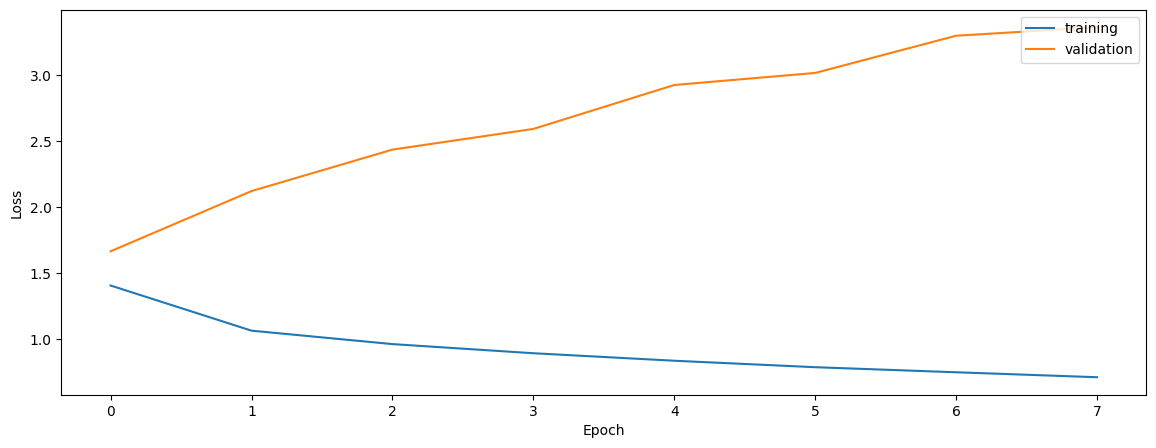

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5566141498512566
0.4110126595222513
0.3194290704253069


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5266329194741822
0.48985799655002465
0.48349212650522694


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5390324506286425
0.4874967865572928
0.514647413225358


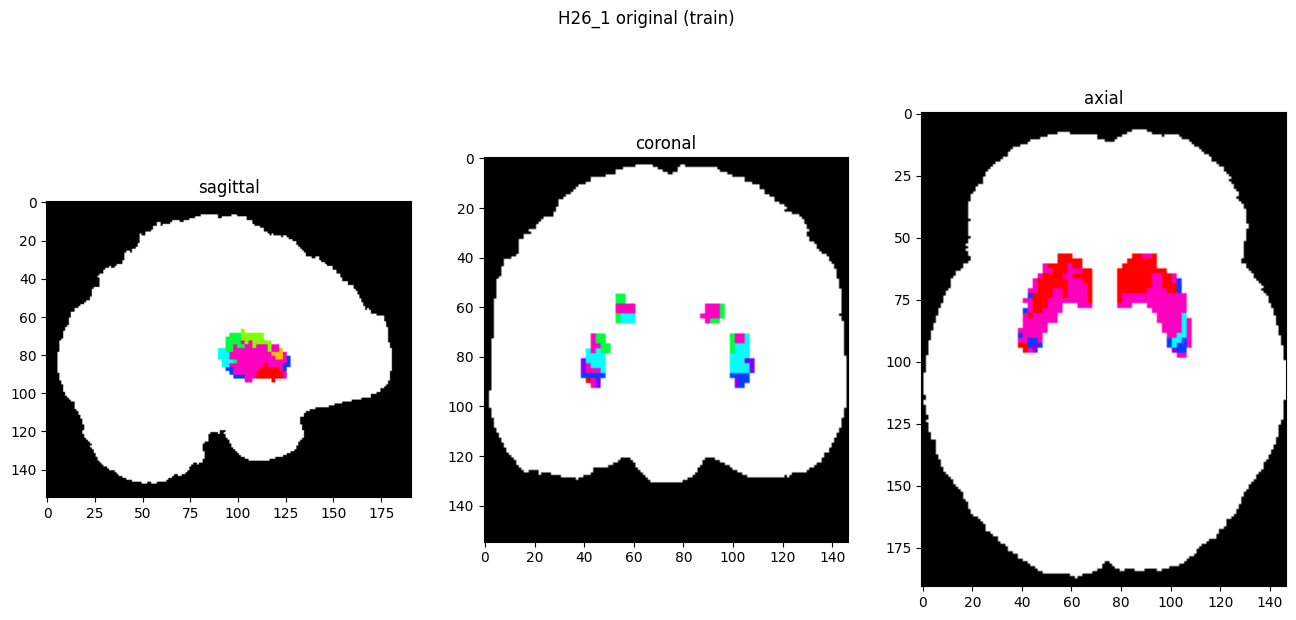

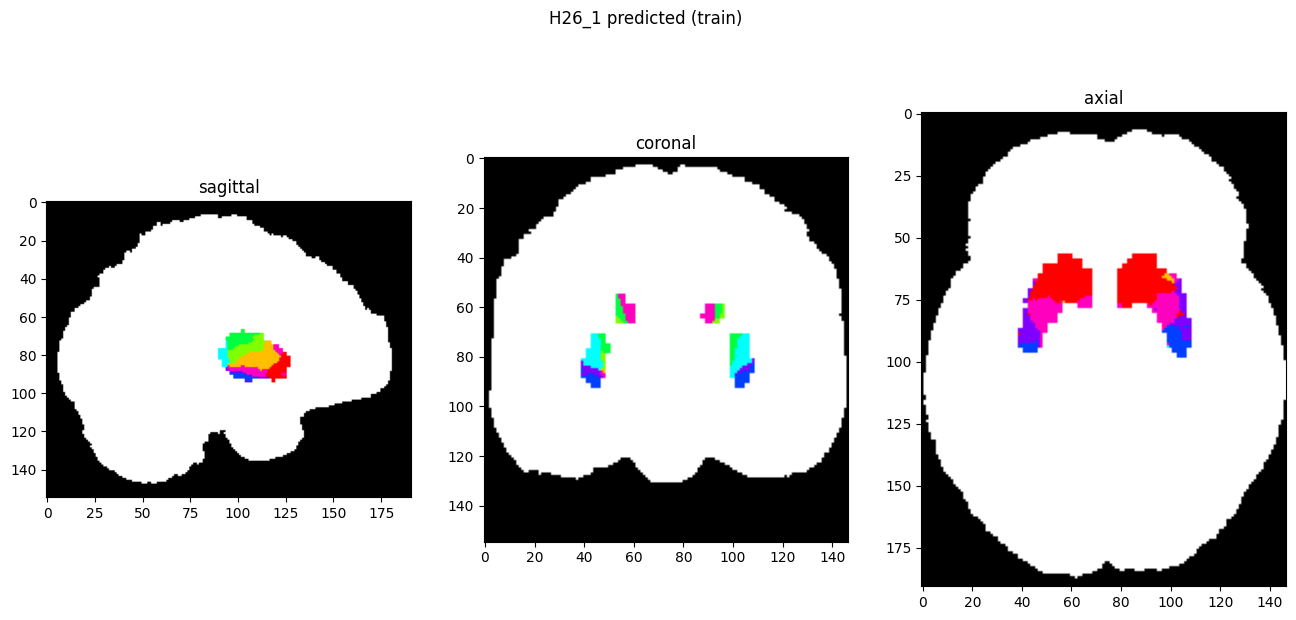

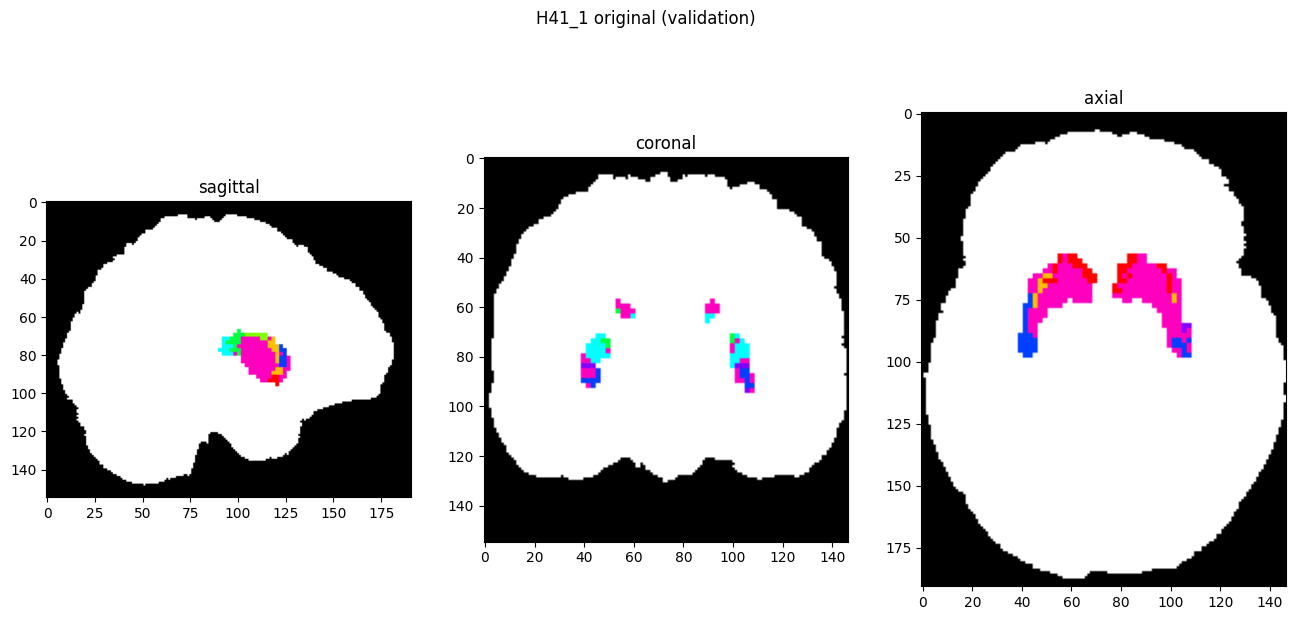

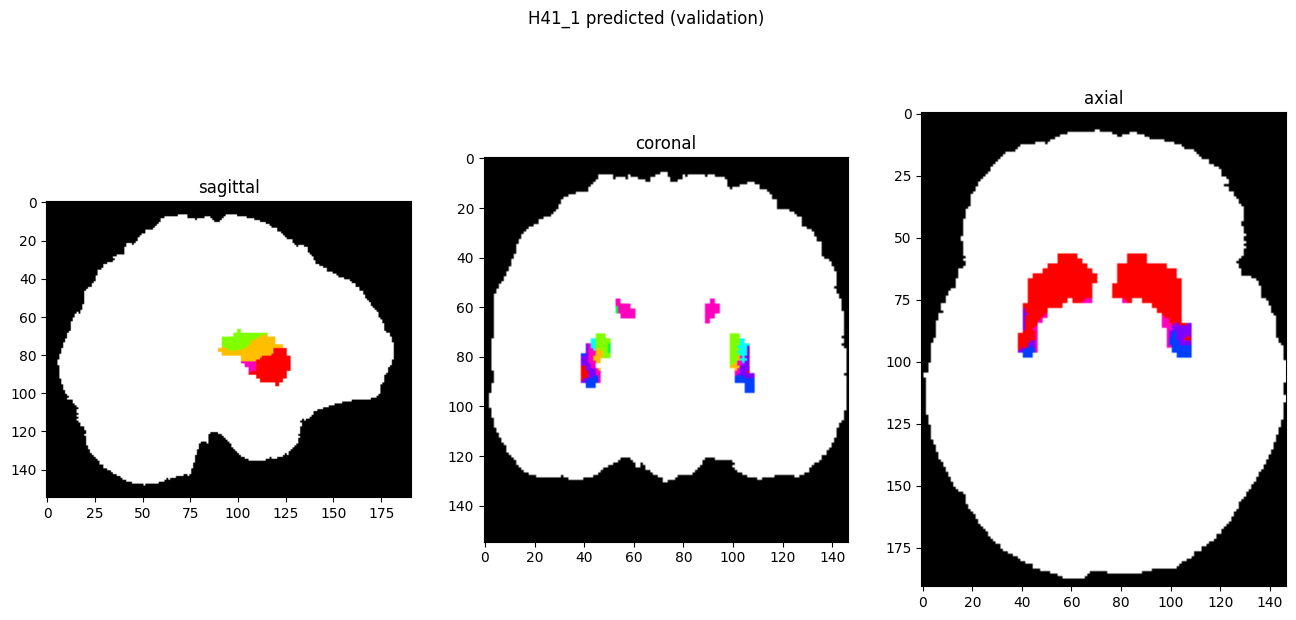

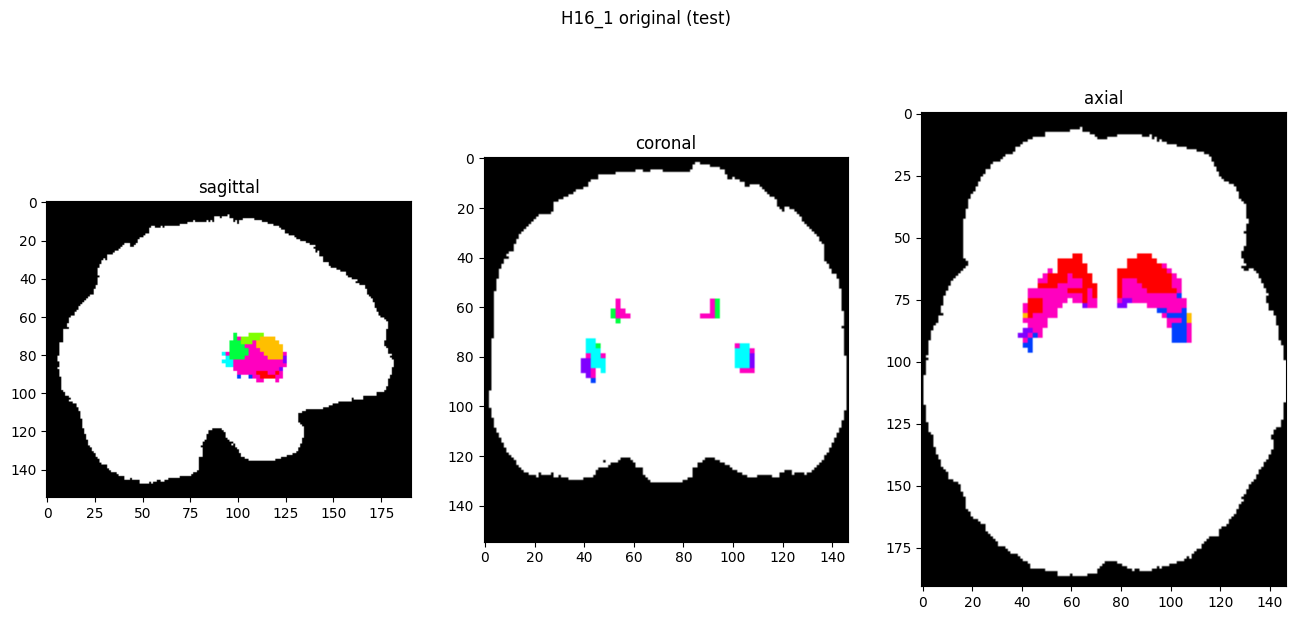

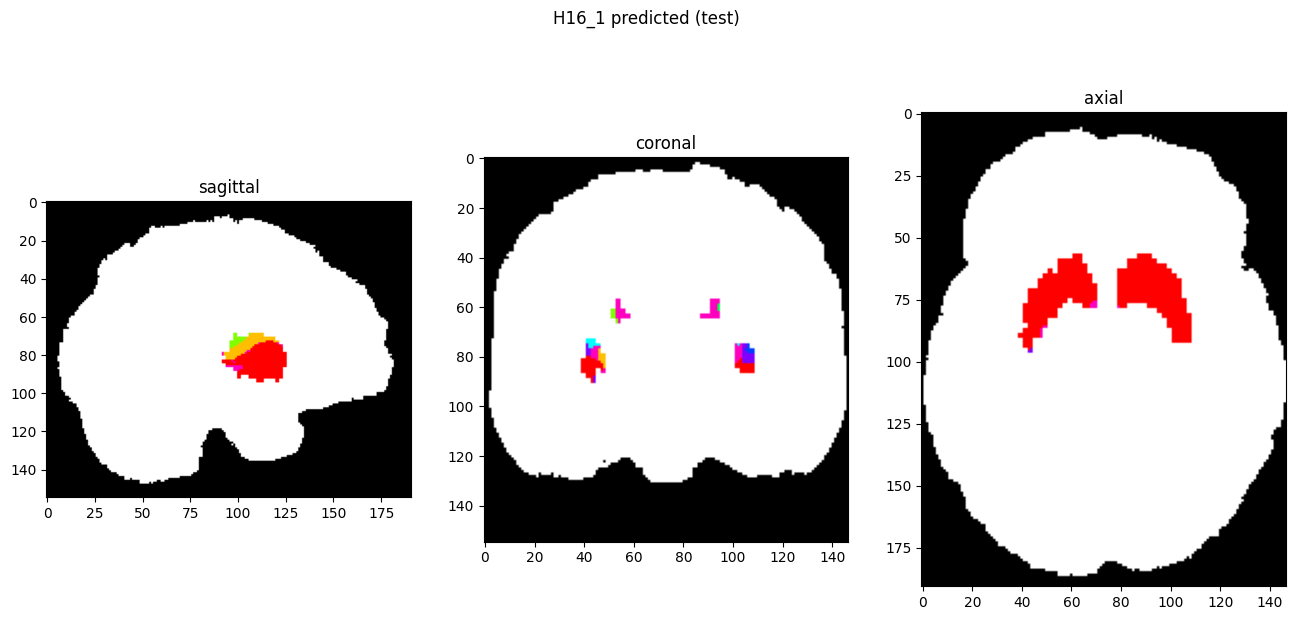

In [10]:
showResults(model, gen, threshold=0)